In [1358]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import os

from math import sqrt
from collections import deque
from src.visualizer.main import Visualizer
from sortedcontainers import SortedSet
from time import time

### Funkcje pomocnicze

In [1359]:
def create():

    def dis(v1,v2):
        return np.sqrt((v1[0]-v2[0])**2+(v1[1]-v2[1])**2)
    
    %matplotlib tk
    polygon=[]
    
    fig, ax = plt.subplots()
    ax.set_xlim(0,1.5)
    ax.set_ylim(0,1.5)
    
    def onclick(event):
        x=event.xdata
        y=event.ydata
        if x is not None and y is not None:
            ax.scatter(x,y)
            if len(polygon)>0:
                plt.plot([polygon[-1][0],x],[polygon[-1][1],y])
            polygon.append((x,y))
            
    
    cid = fig.canvas.mpl_connect('button_press_event', onclick)
    while True:
        if len(polygon)>1:
            if dis(polygon[0],polygon[-1])<0.05:
                polygon.pop()
                %matplotlib inline
                plt.close()
                return polygon
        plt.pause(0.1)  # Aktualizacja wyświetlanego wykresu
    %matplotlib inline
    return polygon

In [1360]:
def det(a, b, c):
    return a[0] * b[1] + a[1] * c[0] + b[0] * c[1] - b[1] * c[0] - a[1] * b[0] - a[0] * c[1]


def which_branch(i, max_i, min_i):
    if max_i > min_i:
        if i > max_i or i <= min_i:
            return "L"
        else:
            return "R"
    else:
        if i > max_i and i <= min_i:
            return "L"
        else:
            return "R"

def belog_to_figure(v1, v2, v3, branch):
    if branch == "L":
        return det(v1, v2, v3) < 0
    else:
        return det(v1, v2, v3) > 0

def is_edge(polygon, p1, p2):
    n = len(polygon)
    return abs(p1 - p2) == 1 or abs(p1 - p2) == n - 1


In [1361]:
def draw_polygon(polygon):
    vis = Visualizer()
    points = polygon
    vis.add_polygon(polygon, fill=False)
    vis.show()

## Pomocniczne funkcje w algortymie triangulacji pierwsza metoda:

### Podział wielokąta na wielokąty monotoniczne

In [1362]:
def is_y_monotonic(polygon):
    n = len(polygon)
    i_y_max = 0
    max_v = polygon[0][1]
    for i in range(1, n):
        if polygon[i][1] > max_v:
            max_v = polygon[i][1]
            i_y_max = i
    i_y_min = 0
    min_v = polygon[0][1]
    for i in range(1, n):
        if polygon[i][1] < min_v:
            min_v = polygon[i][1]
            i_y_min = i
    prev = i_y_max
    while prev != i_y_min:
        if prev == 0:
            curr = n - 1
        else:
            curr = prev - 1
        if polygon[prev][1] <= polygon[curr][1]:
            return False
        prev = curr
    prev = i_y_max
    while prev != i_y_min:
        if prev == n - 1:
            curr = 0
        else:
            curr = prev + 1
        if polygon[prev][1] <= polygon[curr][1]:
            return False
        prev = curr
    return True







### Podział punktów na cztery kategorie

In [1363]:
def color_vertex(polygon):
    n = len( polygon )
    eps = 0
   
    colors=[ 4 for _ in range(n)]
    
    for current in range(0,n):
        previous = current - 1
        nextt = current + 1
        if nextt >= n : nextt = 0
        if previous <= -1 : previous = n - 1
            
        pr=polygon[previous]
        cu=polygon[current]
        ne=polygon[nextt]
        
        if cu[1] > pr[1] and cu[1] > ne[1]:
            if det(pr,cu,ne)>eps:
                colors[current]=0
            else :
                colors[current]=3
        elif cu[1] < pr[1] and cu[1] < ne[1]:
            if det(pr,cu,ne)>eps:
                colors[current]=1
            else:
                colors[current]=2
    return colors
        

### Podział wielokąta przy pomocy algorytmu zamiatania

In [1364]:
def polygon_divison(polygon):
    if is_y_monotonic(polygon):return [[i for i in range(len(polygon))]]

    categories = color_vertex(polygon)

    Q = [i for i in range(len(polygon))]
    Q.sort(reverse=True, key=lambda i: polygon[i][1])

    edges = set()
    i = 0
    while categories[i] != 0:
        i += 1

    direction = 1
    for _ in range(len(polygon) - 1):
        j = i + 1
        if j == len(polygon): j = 0

        if direction == 1:
            edges.add((i, j))
        i = j
        if categories[j] < 4: direction *= -1

    T = SortedSet(None, key=lambda e: polygon[e[1]][0])

    supporter = dict()
    separate_polygons = []
    separate_polygons.append([i for i in range(len(polygon))])

    def get_ev(v):
        v_temp = (v, v)
        T.add(v_temp)
        i = T.index(v_temp)
        T.remove(v_temp)
        if i >= len(T): return T[i - 1]
        if polygon[T[i][0]][0] < polygon[v][0]:
            return T[i]
        else:
            return T[i - 1]


    def devide_polygon(d):
        i = 0

        for i in range(len(separate_polygons)):
            if d[0] in separate_polygons[i] and d[1] in separate_polygons[i]: break
        div_pol = separate_polygons.pop(i)
        a_pol = []
        b_pol = []
        wich = True
        for i in div_pol:
            if i == d[0] or i == d[1]:
                wich = not wich
                a_pol.append(i)
                b_pol.append(i)
            else:
                if wich:
                    a_pol.append(i)
                else:
                    b_pol.append(i)

        separate_polygons.append(a_pol)
        separate_polygons.append(b_pol)

    for v in Q:
        p = v - 1
        n = v + 1
        if n == len(polygon): n = 0
        if p == -1: p = len(polygon) - 1

        if categories[v] == 0:
            T.add((v, n))
            supporter[(v, n)] = v
        if categories[v] == 1:
            if categories[supporter[(p, v)]] == 2:
                if supporter[(p, v)] != p:
                    devide_polygon([supporter[(p, v)], v])
            T.remove((p, v))
        if categories[v] == 2:
            if categories[supporter[(p, v)]] == 2:
                devide_polygon([supporter[(p, v)], v])
            T.remove((p, v))

            ev = get_ev(v)

            if categories[supporter[ev]] == 2:
                devide_polygon([supporter[ev], v])
            supporter[ev] = v
        if categories[v] == 3:
            ev = get_ev(v)
            devide_polygon([supporter[ev], v])
            supporter[ev] = v
            T.add((v, n))
            supporter[(v, n)] = v
        if categories[v] == 4:
            if (p, v) in edges:
                if categories[supporter[(p, v)]] == 2:
                    devide_polygon([supporter[(p, v)], v])
                T.remove((p, v))
                T.add((v, n))
                supporter[(v, n)] = v
            else:
                ev = get_ev(v)
                if categories[supporter[ev]] == 2:
                    devide_polygon([supporter[ev], v])
                supporter[ev] = v
    return separate_polygons

### Triangulacja wielokąta y-monotnicznego

In [1365]:
def triangulation(polygon):
    n = len(polygon)
    points = [i for i in range(n)]

    points.sort(reverse=True, key=lambda y: polygon[y][1])

    max_i = points[-1]
    min_i = points[0]

    triangles = []
    stack = []

    stack.append(points[0])
    stack.append(points[1])

    for i in range(2, n):
        if which_branch(stack[-1], max_i, min_i) != which_branch(points[i], max_i, min_i):  # Różne łańcuchy
            while len(stack) > 0:
                u = stack.pop()
                if len(stack) > 0:
                    triangles.append([polygon[points[i]], polygon[u], polygon[stack[-1]]])
            stack.append(points[i - 1])
            stack.append(points[i])
        else:  # Te same łańcuchy
            u = stack.pop()
            while len(stack) > 0 and belog_to_figure(polygon[points[i]], polygon[stack[-1]], polygon[u],
                                                     which_branch(points[i], max_i, min_i)):
                triangles.append([polygon[points[i]], polygon[u], polygon[stack[-1]]])
                u = stack.pop()
            stack.append(u)
            stack.append(points[i])

    return triangles

## Pomocniczne klasy w algortymie triangulacji delone:

### Klasa do tworzenia funkcji liniowej

In [1366]:
class LineFunction:
    def __init__(self, pointA, pointB):
        self.vertical = False  # atrybut okresla czy nasza funkcja jest pionowa czyli np. x = 3
        self.factorA, self.factorB = self.calculateFactors(pointA, pointB)
        self.pointA = pointA
        self.pointB = pointB
        self.minX = min(pointA.x,pointB.x)
        self.maxX = max(pointA.x, pointB.x)
        self.minY = min(pointA.y, pointB.y)
        self.maxY = max(pointA.y, pointB.y)

    def isPointBelongsToSegment(self,x: float):
        """
        Metoda sprawdza czy dany punkt nalezy do granic naszej prostej
        :param x: Wspolrzedna x-owa danego punktu
        :return: True/False w zaleznosci od tego czy punkt sie miesci w danym przedziale
        """
        if self.maxX >= x >= self.minX:
            return True
        return False

    def calculateFactors(self, a, b):
        """
        Metoda oblicza A i B, we wzorze y = A*x + B
        :param a: Punkt na plaszczyznie R^2
        :param b: Punkt na plaszczyznie R^2
        :return: Obliczone wartosci A i B.
        """
        if a.x == b.x:  # znaczy to ze mamy do czynenia z odcinkiem pionowym - tak wiec trzeba go oznaczyc
            self.vertical = True
            return None, None
        A = (b.y - a.y) / (b.x - a.x)
        B = a.y - A * a.x
        return A, B

    def calculateY(self, x: float):
        """
        Metoda oblicza wartosc y dla danego x w naszej funkji
        :param x: Wspolrzedna x-owa danego punktu
        :return: Wartosc jaka jest osiagana dla tego punktu
        """
        if self.vertical:  # najpiew sprawdzam czy nie jest to napewno odcinek pionowy
            return None
        return x * self.factorA + self.factorB

    def findIntersection(self, other):
        """
        Metoda oblicza przeciecie miedzy dwiema prostymi
        :param other: obiekt klasy LineFunction
        :return: wartosc wspolrzednej x, gdzie sie przecinaja dane proste o ile sie przecinaja, w przeciwnym wypadku jest zwracany None
        """
        if self.vertical and not other.vertical:
            return self.pointA.x

        if not self.vertical and other.vertical:
            return other.pointA.x

        if not self.vertical and not other.vertical and self.factorA != other.factorA:  # mam do czynenia z prostymi nie pionowymi oraz nie rownoleglymi
            return (other.factorB - self.factorB) / (self.factorA - other.factorA)

        return None  # pozostale przypadki

### Klasa do tworzenia punktu

In [1367]:
class Point:
    def __init__(self, x: float, y: float, idPoint: int = -1):
        self.x = x
        self.y = y
        self.idPoint = idPoint


    def toNormalPoint(self):
        return self.x,self.y

    def doesPointContainedWithinTheCircle(self, other):
        """
        Metoda sprawdza czy nasz punkt zawiera sie w okregu opisanym na danym trojkacie
        :param other: Obiekt klasy Triangle
        :return: True/False w zaleznosci czy punkt nalezy okregu opisanym na trojkacie
        """
        middleCircle, radiusOfCircleToSquare = other.desribeTheCircleOnTriangle()
        middleCirclePoint = Point(middleCircle[0], middleCircle[1])
        if (self.x - middleCirclePoint.x) ** 2 + (self.y - middleCirclePoint.y) ** 2 <= radiusOfCircleToSquare:
            return True
        return False

    def doesPointBelongToThisTriangle(self, other):
        """
        Metoda sprawdza czy nasz punkt nalezy do danego trojkata,
        :param other: Obiekt klasy Triangle
        :return: True/False w zaleznosci czy punkt nalezy do trojkata
        """
        lineAB = LineFunction(other.a, other.b)
        lineAC = LineFunction(other.a, other.c)
        lineBC = LineFunction(other.b, other.c)

        verticalCounter = 0

        if lineAB.vertical:
            verticalCounter += 1

        if lineAC.vertical:
            verticalCounter += 1

        if lineBC.vertical:
            verticalCounter += 1

        if verticalCounter > 1:  # znaczy to ze ze nie dosyc ze nawet nie isteniej trojkat ale i punkt w nim takto tez nie moze istniec !
            return False

        if lineAB.isPointBelongsToSegment(self.x) and lineAC.isPointBelongsToSegment(self.x):  # punkt x znajduje sie miedzy prostymi AB oraz AC
           if not lineAC.vertical and not lineAB.vertical:
                if lineAC.calculateY(self.x) >= self.y >= lineAB.calculateY(self.x) or \
                        lineAB.calculateY(self.x) >= self.y >= lineAC.calculateY(self.x):
                    return True

           elif not lineAC.vertical and lineAB.vertical:  # przypadek kiedy prosta AC nie jest liniowa
               top_value = max(lineAC.calculateY(self.x),lineBC.calculateY(self.x))
               min_value = min(lineAC.calculateY(self.x),lineBC.calculateY(self.x))
               if top_value >= self.y >= min_value:
                   return True
               return False

           elif lineAC.vertical and not lineAB.vertical:  # przypadek kiedy prosta AB nie jest liniowa
               top_value = max(lineAB.calculateY(self.x), lineBC.calculateY(self.x))
               min_value = min(lineAB.calculateY(self.x), lineBC.calculateY(self.x))
               if top_value >= self.y >= min_value:
                   return True
               return False

        elif lineBC.isPointBelongsToSegment(self.x) and lineAB.isPointBelongsToSegment(self.x):  # punkt x znajduje sie miedzy prostymi BC oraz AB
            if not lineBC.vertical and not lineAB.vertical:
                if lineBC.calculateY(self.x) >= self.y >= lineAB.calculateY(self.x) or \
                        lineAB.calculateY(self.x) >= self.y >= lineBC.calculateY(self.x):
                    return True

            elif not lineBC.vertical and lineAB.vertical:  # przypadek kiedy prsota BC nie jest liniowa
                top_value = max(lineBC.calculateY(self.x), lineAC.calculateY(self.x))
                min_value = min(lineBC.calculateY(self.x), lineAC.calculateY(self.x))
                if top_value >= self.y >= min_value:
                    return True
                return False

            elif lineBC.vertical and not lineAB.vertical:  # przypadek kiedy prsota AB nie jest liniowa
                top_value = max(lineAB.calculateY(self.x), lineAC.calculateY(self.x))
                min_value = min(lineAB.calculateY(self.x), lineAC.calculateY(self.x))
                if top_value >= self.y >= min_value:
                    return True
                return False

        elif lineBC.isPointBelongsToSegment(self.x) and lineAC.isPointBelongsToSegment(self.x):  # punkt x znajduje sie miedzy prostymi BC oraz AC
            if not lineBC.vertical and not lineAC.vertical:
                if lineBC.calculateY(self.x) >= self.y >= lineAC.calculateY(self.x) or \
                        lineAC.calculateY(self.x) >= self.y >= lineBC.calculateY(self.x):
                    return True

            if lineBC.vertical and not lineAC.vertical:  # przypadek kiedy prsota AC nie jest liniowa
                top_value = max(lineAC.calculateY(self.x), lineAB.calculateY(self.x))
                min_value = min(lineAC.calculateY(self.x), lineAB.calculateY(self.x))
                if top_value >= self.y >= min_value:
                    return True
                return False

            if not lineBC.vertical and lineAC.vertical:  # przypadek kiedy prsota BC nie jest liniowa
                top_value = max(lineBC.calculateY(self.x), lineAB.calculateY(self.x))
                min_value = min(lineBC.calculateY(self.x), lineAB.calculateY(self.x))
                if top_value >= self.y >= min_value:
                    return True
                return False
        return False

    def __eq__(self, other):
        if self.x == other.x and self.y == other.y:
            return True
        return False

    def __lt__(self, other):
        if self.x < other.x:
            return True
        elif self.x == other.x:
            if self.y < other.y:
                return True
            else:
                return False
        else:
            return False

    def __str__(self):
        return f"({self.x},{self.y})"

    def __hash__(self):
        return hash((self.x, self.y))

### Klasa do tworzenia trójkąta

In [1368]:
class Triangle:
    def __init__(self, a, b, c):
        self.a = a
        self.b = b
        self.c = c
        self.firstNeigh = None  # lewy sasiad - inny trojkat z ktorym sasiaduje nasz trojkat
        self.secondNeigh = None  # prawy sasiad
        self.thirdNeigh = None  # trzeci somsiad

    def findTheNearestPoint(self, d):
        """
        Metoda zwraca nam punkt ktory jest najblizej punktu d
        :param d:
        :return:
        """
        distanceAD = sqrt((self.a.x - d.x) ** 2 + (self.a.y - d.y) ** 2)
        distanceBD = sqrt((self.b.x - d.x) ** 2 + (self.b.y - d.y) ** 2)
        distanceCD = sqrt((self.c.x - d.x) ** 2 + (self.c.y - d.y) ** 2)

        minimumDistance = float('inf')
        minimumPoint = None

        if distanceAD < minimumDistance:
            minimumDistance = distanceAD
            minimumPoint = self.a

        if distanceBD < minimumDistance:
            minimumDistance = distanceBD
            minimumPoint = self.b

        if distanceCD < minimumDistance:
            minimumPoint = self.c

        return minimumPoint

    @staticmethod
    def _mat_det_2x2(a, b, c):
        """
        Metoda liczczaca wyznacznik
        :param a: Obiekt klasy Point
        :param b: Obiekt klasy Point
        :param c: Obiekt klasy Point
        :return: Wyznacznik 3 punktow
        """
        return (a.x - c.x) * (b.y - c.y) - (a.y - c.y) * (b.x - c.x)

    def checkTriangleCorrect(self, edge):
        """
        Metoda sprawdzajaca czy dany trojkat jest, trojkatem prawidlowym czyli takim nalezacym do figury, czy tez nie.
        :return:
        """
        newA = edge[0]
        newB = edge[1]
        newC = None

        if self.a != edge[0] and self.a != edge[1]:
            newC = self.a

        elif self.b != edge[0] and self.b != edge[1]:
            newC = self.b

        elif self.c != edge[0] and self.c != edge[1]:
            newC = self.c

        if self._mat_det_2x2(newA, newB, newC) < 0:  # znaczy to, ze dany trojkat nie spelnia wymagan
            return False
        return True

    def whetherEdgesBelongToThisTriangle(self, edge):
        """
        Metoda sprawdza czy dana krawedz nalezy do tego trojkata
        :return:
        """
        edgeCheck = (min(edge[0],edge[1]), max(edge[0],edge[1]))
        edgeAB = (min(self.a, self.b), max(self.a, self.b))
        edgeBC = (min(self.b, self.c), max(self.b, self.c))
        edgeAC = (min(self.a, self.c), max(self.a, self.c))

        if edgeCheck == edgeAB or edgeCheck == edgeBC or edgeCheck == edgeAC:
            return True
        return False

    def findNewDiagonal(self, other):
        """
        Funkcja znajduje nowa przekatna pomiedzy dwoma polaczonymi trojkatami, o ile sie da to zrobic
        :param other:
        :return:
        """
        conectionEdge = self.findTheConnectingSection(other)  # znajduje krawedz laczaca

        firstPointDiagonal = None
        secondPointDiagonal = None

        if conectionEdge is not None:  # sprawdzam czy polaczecie z danym trojaktem istenieje
            edgePointA = conectionEdge[0]
            edgePointB = conectionEdge[1]

            # dla aktualnego trojkata
            if self.a == edgePointA and self.b == edgePointB or self.b == edgePointA and self.a == edgePointB:
                firstPointDiagonal = self.c

            if self.b == edgePointA and self.c == edgePointB or self.c == edgePointA and self.b == edgePointB:
                firstPointDiagonal = self.a

            if self.a == edgePointA and self.c == edgePointB or self.c == edgePointA and self.a == edgePointB:
                firstPointDiagonal = self.b

            # dla other
            if other.a == edgePointA and other.b == edgePointB or other.b == edgePointA and other.a == edgePointB:
                secondPointDiagonal = other.c

            if other.b == edgePointA and other.c == edgePointB or other.c == edgePointA and other.b == edgePointB:
                secondPointDiagonal = other.a

            if other.a == edgePointA and other.c == edgePointB or other.c == edgePointA and other.a == edgePointB:
                secondPointDiagonal = other.b

            return (firstPointDiagonal, secondPointDiagonal, edgePointA),\
                (firstPointDiagonal, secondPointDiagonal, edgePointB)

        return None, None

    def noNeigh(self):
        """
        Metoda zliacza ile nasz trojkat ma sasiadow
        :return:
        """
        counter = 0

        if self.firstNeigh is not None:
            counter += 1
        if self.secondNeigh is not None:
            counter += 1
        if self.thirdNeigh is not None:
            counter += 1
        return counter

    def whetherVertexExist(self,d):
        """
        Metoda sprawdza czy na trojkat posiada wierzcholek d
        :param d: Obiekt klasy Point
        :return: True/False w zaleznosci czy punkt nalezy do naszego trojkata
        """
        if self.a == d or self.b == d or self.c == d:
            return True
        return False

    def whetherNeighExist(self,other):
        """
        Metoda sprawdza czy juz mamy polaczenie z danym sasiadem
        :param other:
        :return:
        """
        if (self.firstNeigh is not None and self.firstNeigh == other) or \
                (self.secondNeigh is not None and self.secondNeigh == other) or \
                (self.thirdNeigh is not None and self.thirdNeigh == other):
            return True
        return False

    def findNewPlaceForNeigh(self):
        """
        Metoda sprawdza najblizszy wolny slot na danego sasiada
        :return: String z nazwa danego atrybutu ktorego mozemy uzyc do przechowania nowego sasiada
        """
        if self.firstNeigh is None:
            return 1
        if self.secondNeigh is None:
            return 2
        if self.thirdNeigh is None:
            return 3

        return None

    def whichNeigh(self, other):
        """
        Metoda sprawdza ktorym sasiadem z kolejnosci jestesmy dla innego trojkata
        :param other: Obiekt klasy Triangle
        :return: 1/2/3 - w zaleznosci kotrym sasiadem jestesmy
        """

        if other.firstNeigh is not None and other.firstNeigh == self:
            return 1
        if other.secondNeigh is not None and other.secondNeigh == self:
            return 2
        if other.thirdNeigh is not None and other.thirdNeigh == self:
            return 3

        return None

    def findTheConnectingSection(self, other):
        """
        Metoda znajduje dwa punkty symboluzujace odcinek o ile istnieje, ktory laczy dwa trojkaty
        :return: Krotka dwoch punktow symbolizujaca odcinek
        """
        sectionAB = (min(self.a, self.b), max(self.a, self.b))
        sectionBC = (min(self.b, self.c), max(self.b, self.c))
        sectionAC = (min(self.a, self.c), max(self.a, self.c))

        sectionABprim = (min(other.a, other.b), max(other.a, other.b))
        sectionBCprim = (min(other.b, other.c), max(other.b, other.c))
        sectionACprim = (min(other.a, other.c), max(other.a, other.c))

        if sectionAB == sectionABprim or sectionAB == sectionBCprim or sectionAB == sectionACprim:
            return sectionAB

        if sectionBC == sectionACprim or sectionBC == sectionABprim or sectionBC == sectionBCprim:
            return sectionBC

        if sectionAC == sectionACprim or sectionAC == sectionABprim or sectionAC == sectionBCprim:
            return sectionAC

        return None

    def desribeTheCircleOnTriangle(self):
        """
        Metoda opisujaca okrag na trojkacie, czyli po prostu na trzech punktach
        :return: Krotka zawierajaca obiekt klasy Point, gdzie trzymane sa wsporzedne srodka punktu, oraz promien do kwadratu
        """
        numerator_x_s = (self.a.x ** 2 + self.a.y ** 2) * (self.b.y - self.c.y) + \
                        (self.b.x ** 2 + self.b.y ** 2) * (self.c.y - self.a.y) + \
                        (self.c.x ** 2 + self.c.y ** 2) * (self.a.y - self.b.y)

        denominator_x_s = self.a.x * (self.b.y - self.c.y) + self.b.x * (self.c.y - self.a.y) + \
                          self.c.x * (self.a.y - self.b.y)

        x_s = 1 / 2 * (numerator_x_s / denominator_x_s)

        numerator_y_s = (self.a.x ** 2 + self.a.y ** 2) * (self.c.x - self.b.x) + \
                        (self.b.x ** 2 + self.b.y ** 2) * (self.a.x - self.c.x) + \
                        (self.c.x ** 2 + self.c.y ** 2) * (self.b.x - self.a.x)

        denominator_y_s = self.a.x * (self.b.y - self.c.y) + self.b.x * (self.c.y - self.a.y) + \
                          self.c.x * (self.a.y - self.b.y)

        y_s = 1 / 2 * (numerator_y_s / denominator_y_s)

        radiusOfCircleToSquare = (x_s - self.a.x) ** 2 + (y_s - self.a.y) ** 2

        return (x_s, y_s), radiusOfCircleToSquare

    def __eq__(self, other):
        if self.a == other.a and self.b == other.b and self.c == other.c or \
                self.a == other.b and self.b == other.a and self.c == other.c or \
                self.a == other.b and self.b == other.c and self.c == other.a or \
                self.a == other.a and self.b == other.c and self.c == other.b or \
                self.a == other.c and self.b == other.a and self.c == other.b or \
                self.a == other.c and self.b == other.b and self.c == other.a:  # znajduje wszystkie mozliwe permutacje
            return True
        return False

    def __str__(self):
        return f"A - {self.a}; B - {self.b}; C - {self.c}"

    def __hash__(self):
        return hash((self.a, self.b, self.c))

### Funkcja pomocnicza wyznaczająca trzy skrajne punkty dla naszych wielokatów

In [1369]:
def extremePoints(polygon):  # O(n)
    """
    Funkcja wyznacza trzy skrajne punkty dla naszego wielokata prostego.
    :param polygon: tablica krotek punktów na płaszczyźnie euklidesowej podanych przeciwnie do ruchu wskazówek zegara
    :return: (a,b,c) - gdzie a,b,c sa to krotki punktow (x,y) na plaszyznie R^2 odpowiadaja odpowiednio: lewym dolnym, prawym dolnym i gornym wierzcholkiem
    """
    n = len(polygon)
    x_min = float('inf')
    x_max = float('-inf')
    y_min = float('inf')
    y_max = float('-inf')

    for a in polygon:
        if a[0] < x_min:
            x_min = a[0]
        if a[0] > x_max:
            x_max = a[0]
        if a[1] < y_min:
            y_min = a[1]
        if a[1] > y_max:
            y_max = a[1]

    a = abs(x_max - x_min)  # dlugosc boku prostokata
    b = abs(y_max - y_min)  # dlugosc boku prostokata

    left_bottom_point = Point(x_min - 2 * max(a, b), y_min - min(a, b), n)
    right_bottom_point = Point(x_max + 2 * max(a, b), y_min - min(a, b), n + 1)

    to_add = abs(right_bottom_point.x - x_max) * 0.05

    left_upper_rectangular_point = Point(x_min - to_add,y_max)  # lewy gory wierzcholek prostokata - nie daje tym punktom indeksow ponieaz sa tymczasowe
    right_upper_rectangular_point = Point(x_max + to_add, y_max)  # prawy gorny wierzcholek prostokata

    leftLine = LineFunction(left_bottom_point, left_upper_rectangular_point)
    rightLine = LineFunction(right_bottom_point, right_upper_rectangular_point)

    x = leftLine.findIntersection(rightLine)  # punkt przeciecia obu prostych

    middle_upper_point = Point(x, leftLine.calculateY(x), n + 2)

    return Triangle(left_bottom_point, right_bottom_point, middle_upper_point)

### Funkcja pomocznia do inicializacji poczatkowej wartosci zbioru - aby poprawnie działał BFS

In [1370]:
def iniclizationVisited(triangleTab: set):  # O(n)
    """
    Funkcja sluzaca do inicializacji poczatkowej tablicy porzechowujacej informacje o tym czy bylismy w danym trojkacie
    :param triangleTab:
    :return:
    """
    visited = {}
    for triangle in triangleTab:
        visited[triangle] = False
    return visited

### Funkcja przeszukjąca kolejne trójkąty algortymem pseudo BFS - aby wyznaczyc te ktore spelniaja warunek okregu

In [1371]:
def bfsTriangleSearcherMapCreator(triangleMap: set, startTriangle: Triangle, startPoint: Point):  # O(n)
    """
    Funkcja przesukuje kolejne trojkaty w naszej aktualnej triangulacji aby wybrac te, ktore spelniaja warunek okregu
    :param triangleMap: Tabila trojkatow
    :param startTriangle: Trojkat od ktorego zaczynamy
    :param startPoint: Punkt z ktorym bedziemy poronywac kazdy trojkat
    :return: Mapa trojkatow na ktorych opisany okrag zawiera nasz punkt
    """
    visited = iniclizationVisited(
        triangleMap)  # slownik sluzaca do przechowywania infomracji o tym czy juz odwiedzalem dany trojkat
    toSearchTriangleMap = {startTriangle}  # slownik ktora zostanie uzupelniona trojkatami do przejzenia w przyszlosci

    Q = deque()
    Q.append(startTriangle)
    visited[startTriangle] = True

    while len(Q) > 0:
        v = Q.popleft()

        if v.firstNeigh is not None and v.firstNeigh in visited and visited[v.firstNeigh] is False:
            if startPoint.doesPointContainedWithinTheCircle(v.firstNeigh):
                toSearchTriangleMap.add(v.firstNeigh)

                visited[v.firstNeigh] = True  # interesuje mnie dodanie elementow do kolejki ktore spelniaja moje wymagania
                Q.append(v.firstNeigh)

        if v.secondNeigh is not None and v.firstNeigh in visited and visited[v.secondNeigh] is False:
            if startPoint.doesPointContainedWithinTheCircle(v.secondNeigh):
                toSearchTriangleMap.add(v.secondNeigh)

                visited[v.secondNeigh] = True
                Q.append(v.secondNeigh)

        if v.thirdNeigh is not None and v.firstNeigh in visited and visited[v.thirdNeigh] is False:
            if startPoint.doesPointContainedWithinTheCircle(v.thirdNeigh):
                toSearchTriangleMap.add(v.thirdNeigh)

                visited[v.thirdNeigh] = True
                Q.append(v.thirdNeigh)

    return toSearchTriangleMap

### Funkcja aktualizuje sasiadow naszych trojątów które zostały nowo-utworzone

In [1372]:
def updateNeighOfTheTriangles(newTriangles: set[Triangle]):  # O(n)
    """
    Funkcja aktualizuje sasiadow naszych trojkatow nowo utworzonych miedzy soba
    :param newTriangles: Nowo utworzona mapa trojkatow ktora bede przegladal i patrzyl czy sie przypadkiem nie przecina
    :return: Nic, poniewaz wszystko jest zmieniane przez referencje
    """

    for triangleA in newTriangles:  # przegladam kazdego trojkata z kazdym i bede je porownywal
        for triangleB in newTriangles:
            if triangleA != triangleB:
                sectionTrangles = triangleA.findTheConnectingSection(triangleB)  # znajduje przeciecie o ile istnieje
                if sectionTrangles is not None:
                    if not triangleA.whetherNeighExist(triangleB):  # jesli nie mamy infomracji o przechowywaniu sasiada to musimy go koniecznie dodac
                        whichSlotIsFree = triangleA.findNewPlaceForNeigh()
                        if whichSlotIsFree == 1:
                            triangleA.firstNeigh = triangleB
                        if whichSlotIsFree == 2:
                            triangleA.secondNeigh = triangleB
                        if whichSlotIsFree == 3:
                            triangleA.thirdNeigh = triangleB
                    # w druga strone nie sprawdzam poniewaz i tak petla natrafie na taki przypadek

### Funkcja sluzaca do usuwania starych trojkatow ktore spelniaja warunek okregu i stworzenia nowych zgodnie z algortymem

In [1373]:
def bfsTriangleEdgeRemover(triangleMap: set[Triangle], startTriangle: Triangle, startPoint: Point,
                           toSearchTriangleMap: set[Triangle], zeroTriangle: Triangle):  # O(n)
    """
    Funkcja sluzaca do usuwania krawedzi miedzy trojkatami a nastepnie stworzenie nowych trojkatow i zmienienie sasiadow na nowe trojkaty
    :param triangleMap:
    :param startTriangle:
    :param startPoint:
    :param toSearchTriangleMap:
    :param zeroTriangle:
    :return:
    """
    visited = iniclizationVisited(
        triangleMap)  # slownik sluzaca do przechowywania infomracji o tym czy juz odwiedzalem dany trojkat

    Q = deque()
    Q.append(startTriangle)
    visited[startTriangle] = True

    newTriangles = set()

    while len(Q) > 0:
        v = Q.popleft()
        triangleMap.remove(v)  # usuwam z mojej mapy trojaktow moj aktualny trojkat poniewaz beda zmieniane
        neighCounter = 0  # licznik ktory opisuje do ilu sasiadow moge isc

        if v.firstNeigh is not None and v.firstNeigh in visited and visited[v.firstNeigh] is False and v.firstNeigh in toSearchTriangleMap:
            visited[v.firstNeigh] = True
            Q.append(v.firstNeigh)
            neighCounter += 1

        if v.secondNeigh is not None and v.secondNeigh in visited and visited[v.secondNeigh] is False and v.secondNeigh in toSearchTriangleMap:
            visited[v.secondNeigh] = True
            Q.append(v.secondNeigh)
            neighCounter += 1

        if v.thirdNeigh is not None and v.thirdNeigh in visited and visited[v.thirdNeigh] is False and v.thirdNeigh in toSearchTriangleMap:
            visited[v.thirdNeigh] = True
            Q.append(v.thirdNeigh)
            neighCounter += 1

        if neighCounter != 3:  # znaczy ze aktualny trojkat jest brzegowym - bede aktualizowal sasiadow
            if v.firstNeigh is not None and not v.firstNeigh in toSearchTriangleMap:  # znaczy ze ten sasiad bede potrzebowal innego sasiada
                whichNeighWeAre = v.whichNeigh(v.firstNeigh)  # sprawdzamy ktorym sasiadem dokladnie jestesmy, aby moc to zmienic
                a, b = v.findTheConnectingSection(v.firstNeigh)  # znajduje punkty w ktorych lacza sie dane trojkaty

                newTrianlge = Triangle(a, b, startPoint)  # tworze nowy trojkat zaczynajac od laczenia
                newTrianlge.firstNeigh = v.firstNeigh  # dodaje do nowego trojkata starego sasiada - zawsze bedziemy go dodawac jako pierwszego
                triangleMap.add(newTrianlge)  # dodaje do zbioru nowo utworzony trojkat
                newTriangles.add(newTrianlge)  # dodaje do zbioru nowo utworzony trojkat tylko, ze w tym mam tylko nowo dodane trojkaty

                if whichNeighWeAre == 1:
                    v.firstNeigh.firstNeigh = newTrianlge
                if whichNeighWeAre == 2:
                    v.firstNeigh.secondNeigh = newTrianlge
                if whichNeighWeAre == 3:
                    v.firstNeigh.thirdNeigh = newTrianlge

            if v.secondNeigh is not None and not v.secondNeigh in toSearchTriangleMap:
                whichNeighWeAre = v.whichNeigh(v.secondNeigh)
                a, b = v.findTheConnectingSection(v.secondNeigh)

                newTrianlge = Triangle(a, b, startPoint)
                newTrianlge.firstNeigh = v.secondNeigh
                triangleMap.add(newTrianlge)
                newTriangles.add(newTrianlge)

                if whichNeighWeAre == 1:
                    v.secondNeigh.firstNeigh = newTrianlge
                if whichNeighWeAre == 2:
                    v.secondNeigh.secondNeigh = newTrianlge
                if whichNeighWeAre == 3:
                    v.secondNeigh.thirdNeigh = newTrianlge

            if v.thirdNeigh is not None and not v.thirdNeigh in toSearchTriangleMap:
                whichNeighWeAre = v.whichNeigh(v.thirdNeigh)
                a, b = v.findTheConnectingSection(v.thirdNeigh)

                newTrianlge = Triangle(a, b, startPoint)
                newTrianlge.firstNeigh = v.thirdNeigh
                triangleMap.add(newTrianlge)
                newTriangles.add(newTrianlge)

                if whichNeighWeAre == 1:
                    v.thirdNeigh.firstNeigh = newTrianlge
                if whichNeighWeAre == 2:
                    v.thirdNeigh.secondNeigh = newTrianlge
                if whichNeighWeAre == 3:
                    v.thirdNeigh.thirdNeigh = newTrianlge

            if v.firstNeigh is None or v.secondNeigh is None or v.thirdNeigh is None:  # znaczy ze naszym sasiadujacym trojkatem jest trojkat glowny - bo innej opcji nie ma
                a, b = v.findTheConnectingSection(zeroTriangle)

                newTrianlge = Triangle(a, b, startPoint)
                triangleMap.add(newTrianlge)
                newTriangles.add(newTrianlge)

    updateNeighOfTheTriangles(newTriangles)  # dodaje reszte sasiadow

    return triangleMap

### Funkcja sluzaca do wstawienia nowych trojkatow tylko w specyficznym przypadku kiedy zaden sasiad nie spelnial warunku okregu

In [1374]:
def updateMapForOneTriangle(triangleMap: set, startPoint: Point, startTriangle: Triangle, zeroTriangle: Triangle):
    """
    Funkcja sluzy temu aby zaktualizowac mape trojkatow w przypadku kiedy ten dany trojkat spelnia jako jedyny zalozenia
    :param triangleMap: Mapa trojkatow
    :param startPoint: Punkt startowy
    :return:
    """
    triangleMap.remove(startTriangle)  # usuwam poczatkowy trojkat
    flag = False  # flaga sluzaca temu po prostu czy jaki kolwiek z warunkow nie bedzie spelniony
    newTriangles = set()

    if startTriangle.firstNeigh is not None:
        whichNeighWeAre = startTriangle.whichNeigh(startTriangle.firstNeigh)
        a, b = startTriangle.findTheConnectingSection(startTriangle.firstNeigh)

        newTrianlge = Triangle(a, b, startPoint)
        newTrianlge.firstNeigh = startTriangle.firstNeigh
        triangleMap.add(newTrianlge)
        newTriangles.add(newTrianlge)

        if whichNeighWeAre == 1:
            startTriangle.firstNeigh.firstNeigh = newTrianlge
        if whichNeighWeAre == 2:
            startTriangle.firstNeigh.secondNeigh = newTrianlge
        if whichNeighWeAre == 3:
            startTriangle.firstNeigh.thirdNeigh = newTrianlge

    else:
        flag = True

    if startTriangle.secondNeigh is not None:
        whichNeighWeAre = startTriangle.whichNeigh(startTriangle.secondNeigh)
        a, b = startTriangle.findTheConnectingSection(startTriangle.secondNeigh)

        newTrianlge = Triangle(a, b, startPoint)
        newTrianlge.firstNeigh = startTriangle.secondNeigh
        triangleMap.add(newTrianlge)
        newTriangles.add(newTrianlge)

        if whichNeighWeAre == 1:
            startTriangle.secondNeigh.firstNeigh = newTrianlge
        if whichNeighWeAre == 2:
            startTriangle.secondNeigh.secondNeigh = newTrianlge
        if whichNeighWeAre == 3:
            startTriangle.secondNeigh.thirdNeigh = newTrianlge

    else:
        flag = True

    if startTriangle.thirdNeigh is not None:
        whichNeighWeAre = startTriangle.whichNeigh(startTriangle.thirdNeigh)
        a, b = startTriangle.findTheConnectingSection(startTriangle.thirdNeigh)

        newTrianlge = Triangle(a, b, startPoint)
        newTrianlge.firstNeigh = startTriangle.thirdNeigh
        triangleMap.add(newTrianlge)
        newTriangles.add(newTrianlge)

        if whichNeighWeAre == 1:
            startTriangle.thirdNeigh.firstNeigh = newTrianlge
        if whichNeighWeAre == 2:
            startTriangle.thirdNeigh.secondNeigh = newTrianlge
        if whichNeighWeAre == 3:
            startTriangle.thirdNeigh.thirdNeigh = newTrianlge

    else:
        flag = True

    if flag:
        a, b = startTriangle.findTheConnectingSection(zeroTriangle)

        newTrianlge = Triangle(a, b, startPoint)
        triangleMap.add(newTrianlge)
        newTriangles.add(newTrianlge)

    updateNeighOfTheTriangles(newTriangles)  # dodaje reszte sasiadow do moich nowododanych trojkatow

    return triangleMap

### Funkcja znajdujące trojkat w ktorym jest nasz aktualnie przegladany punkt

In [1375]:
def dfsFindPoint(triangleMap: set[Triangle], point: Point):
    """
    Funkcja znjadujaca trojkat na ktorym lezy nasz punkt algortem DFS, ale w kolejnosci odpowiedniej dlugosci
    :param triangleMap:
    :param point:
    :return:
    """
    visited = iniclizationVisited(triangleMap)

    found = False
    searchedTriangle = None

    def dfsStart(triangleMap: set[Triangle]):
        for triangle in triangleMap:
            if visited[triangle] is False:
                dfsVisit(triangleMap, triangle)

                if found:
                    break

    def dfsVisit(triangleMap: set[Triangle], triangle: Triangle):
        nonlocal point, searchedTriangle, found

        if point.doesPointBelongToThisTriangle(triangle):
            searchedTriangle = triangle
            found = True

        if not found:

            visited[triangle] = True

            minimumPoint = None
            miniumDistance = None
            who_started = -1

            if triangle.firstNeigh is not None and visited[triangle.firstNeigh] is False:
                minimumPointAct = triangle.firstNeigh.findTheNearestPoint(point)
                distanceAct = sqrt((minimumPointAct.x - point.x) ** 2 + (minimumPointAct.y - point.y) ** 2)

                miniumDistance = distanceAct
                minimumPoint = minimumPointAct
                who_started = 1

            if triangle.secondNeigh is not None and visited[triangle.secondNeigh] is False:
                minimumPointAct = triangle.secondNeigh.findTheNearestPoint(point)
                if minimumPoint is not None:
                    distanceAct = sqrt((minimumPointAct.x - minimumPoint.x) ** 2 + (minimumPointAct.y - minimumPoint.y) ** 2)

                    if distanceAct < miniumDistance:
                        miniumDistance = distanceAct
                        minimumPoint = minimumPointAct
                        who_started = 2
                else:
                    distanceAct = sqrt((minimumPointAct.x - point.x) ** 2 + (minimumPointAct.y - point.y) ** 2)

                    miniumDistance = distanceAct
                    minimumPoint = minimumPointAct
                    who_started = 2

            if triangle.thirdNeigh is not None and visited[triangle.thirdNeigh] is False:
                minimumPointAct = triangle.secondNeigh.findTheNearestPoint(point)
                if minimumPoint is not None:
                    distanceAct = sqrt((minimumPointAct.x - minimumPoint.x) ** 2 + (minimumPointAct.y - minimumPoint.y) ** 2)

                    if distanceAct < miniumDistance:
                        who_started = 3
                else:
                    who_started = 3

            if who_started == 1:
                dfsVisit(triangleMap, triangle.firstNeigh)

            if who_started == 2:
                dfsVisit(triangleMap, triangle.secondNeigh)

            if who_started == 3:
                dfsVisit(triangleMap, triangle.thirdNeigh)

            if triangle.firstNeigh is not None and visited[triangle.firstNeigh] is False:
                dfsVisit(triangleMap, triangle.firstNeigh)

            if triangle.secondNeigh is not None and visited[triangle.secondNeigh] is False:
                dfsVisit(triangleMap, triangle.secondNeigh)

            if triangle.thirdNeigh is not None and visited[triangle.thirdNeigh] is False:
                dfsVisit(triangleMap, triangle.thirdNeigh)

    dfsStart(triangleMap)
    return searchedTriangle

### Funkcja inicializujaca poczatkowe wartosci dla slownika trojkatow

In [1376]:
def inicializeWithStartTriangle(pointTab, zeroTriangle):
    """
    Funkcja inicializuje poczatkowe wartosci dla slownika trojkatow, ktory bedzie dalej rozwijany przez caly proces trwania naszego algortymu
    :param pointTab:
    :param zeroTriangle:
    :return:
    """
    tran1 = Triangle(zeroTriangle.a, zeroTriangle.b, pointTab[0])
    tran2 = Triangle(zeroTriangle.a, zeroTriangle.c, pointTab[0])
    tran3 = Triangle(zeroTriangle.c, zeroTriangle.b, pointTab[0])

    # ustalam sasiadow poszczegolnych trojkatow
    tran1.firstNeigh = tran2
    tran1.secondNeigh = tran3

    tran2.firstNeigh = tran3
    tran2.secondNeigh = tran1

    tran3.firstNeigh = tran2
    tran3.secondNeigh = tran1

    return {tran1, tran2, tran3}

### Funkcja usuwajaca trójkąt główny dodany na samym początku oraz incydentne z nim krawędzie

In [1377]:
def deletedBorder(triangleMap: set[Triangle], zeroTriangle: Triangle):
    """
    Funkcja usuuwa obramowanie
    :return:
    """
    triagleSol = set()
    for triangle in triangleMap:
        if not triangle.whetherVertexExist(zeroTriangle.a) and \
                not triangle.whetherVertexExist(zeroTriangle.b) and \
                not triangle.whetherVertexExist(zeroTriangle.c):
            triagleSol.add(triangle)

    return triagleSol

### Funkcja tworzy zbior krawedzi ze wszystkich trojkatow ktore istnieja ale dodaje je jako obiekty klasy Point

In [1378]:
def createSetEdgesToPrintAll(triagleSol: set[Triangle]):
    """
    Funkcja tworzy zbior krwawedzi ze wszystkich trojkatow obiektow Point
    :param triagleSol:
    :return:
    """
    edgesSet = set()
    for triangle in triagleSol:
        if not (triangle.a,triangle.b) in edgesSet and not (triangle.b,triangle.a) in edgesSet:
            edgesSet.add((triangle.a,triangle.b))

        if not (triangle.a,triangle.c) in edgesSet and not (triangle.c,triangle.a) in edgesSet:
            edgesSet.add((triangle.a,triangle.c))

        if not (triangle.b, triangle.c) in edgesSet and not (triangle.c, triangle.b) in edgesSet:
            edgesSet.add((triangle.b, triangle.c))

    return edgesSet

### Funkcja przerabia zbior punktow krawedziowych klasy Point na prawdziwe krotki z punktami

In [1379]:
def createListEdges(edgesSet: set[(Point,Point)]):
    """
    Funcja przerabia zbior punktow na prawdzia liste krotek krawedzi
    :param edgesSet:
    :return:
    """
    listEdges = []

    for edges in edgesSet:
        point1 = edges[0]
        point2 = edges[1]
        listEdges.append( ((point1.x,point1.y),(point2.x,point2.y)) )

    return listEdges

### Funkcja tworzy tablice obiektow typu Point

In [1380]:
def createPointTab(polygon):  # O(n)
    """
    Funkcja tworzy tablice obiektow typu Point, aby moc wygodnie na nich dzialac
    :param polygon: Tablica punktow
    :return: Tablica obiektow typu Point
    """
    n = len(polygon)
    pointTab = []

    for i in range(n):
        point = polygon[i]
        newPoint = Point(point[0], point[1], i)
        pointTab.append(newPoint)

    return pointTab

### Funkcja tworzy zbior krawedzi które należa do wielokąta

In [1381]:
def createSetEdges(pointTab: list[Point]):
    """
    Funkcja dla poczatkowego zbioru punktow, tworzy poczatkowy zbior krawedzi.
    :param pointTab:
    :return: Tablica krawedzi krotek obietkow typu Point, ktore symbolizuja dane krawedzie
    """
    n = len(pointTab)
    edgesSet = set()  # zbior krawedzi

    for i in range(n - 1):
        point1 = pointTab[i]
        point2 = pointTab[i + 1]
        edgesSet.add((point1, point2))

    point1 = pointTab[-1]
    point2 = pointTab[0]
    edgesSet.add((point1, point2))

    return edgesSet

### Funkcja znajduje wszystkie trójkaty które przecinają daną krawedz naszego wieloboku

In [1382]:
def findCuttersEdges(edgesSet: set[tuple[Point,Point]], triangleToDetector: set[Triangle]):  # O(n)
    """
    Funkcja znajduje wszystkie trojkaty ktore przecinaja krawedzie naszej figry
    :param edgesSet:
    :param triangleToDetector:
    :return: Mapa z kluczem jako krawedz, a z wartosciami jako lista trojkatow ktore przecinaja dana krawedz
    """
    cuttersMap = dict()

    for edge in edgesSet:
        cuttersMap[edge] = []  # tworze to jako tablice aby moc latwo iterowac sie po tym

        for triangle in triangleToDetector:
            if isCut(triangle, edge):  # dany trojkat przecina dana krawedz
                cuttersMap[edge].append(triangle)

    return cuttersMap

### Funkcja odpowiada na pytanie czy dany trojkat przecina dana krawedz

In [1383]:
def isCut(triangle: Triangle, edge: tuple[Point,Point]):
    """
    Funkcja odpowiada na pytania czy dany trojkat, przecina dana krawedz.
    Funkcja ta bedzie pomocna przy procedurze odzyskiwania krawedzi
    :return: True/False w zaleznosci czy dany punkt przecina dana krawedz
    """
    edgeAB = (triangle.a, triangle.b)
    edgeAC = (triangle.a, triangle.c)
    edgeBC = (triangle.b, triangle.c)

    if whetherTwoEdgesCut(edgeAB, edge) or \
            whetherTwoEdgesCut(edgeAC, edge) or \
            whetherTwoEdgesCut(edgeBC, edge):
        return True
    return False

### Funkcja odpowiada na pytanie czy dane odcinki sie przecinaja

In [1384]:
def whetherTwoEdgesCut(edgeA: tuple[Point, Point], edgeB: tuple[Point, Point]):

    if edgeA[0] == edgeB[0] or edgeA[0] == edgeB[1] or edgeA[1] == edgeB[0] or edgeA[1] == edgeB[1]: return False

    o1 = get_orientation(mat_det_2x2(edgeA[0],edgeA[1],edgeB[0]))
    o2 = get_orientation(mat_det_2x2(edgeA[0],edgeA[1],edgeB[1]))

    o3 = get_orientation(mat_det_2x2(edgeB[0],edgeB[1],edgeA[0]))
    o4 = get_orientation(mat_det_2x2(edgeB[0],edgeB[1],edgeA[1]))

    if o1 != o2 and o3 != o4:
        return True

    return False

### Funkcje pomocznicze do okreslenia czy dwa odcniki sie przecinaja

In [1385]:
def get_orientation(actuall_orientation):
    if actuall_orientation > 0: return 1
    elif actuall_orientation < 0: return -1
    return 0

def mat_det_2x2(a: Point, b: Point, c: Point): #wyznacznik 2x2
    return (a.x-c.x)*(b.y-c.y)-(a.y-c.y)*(b.x-c.x)

### Funkcje usuwajaca dany trojkat

In [1386]:
def deleteTriangle(cuttersMap: dict[tuple[Point,Point], list[Triangle]], triangle: Triangle):  # O(n)
    """
    Funkcja usuwa dla danego trojkat z cuttersMap, czyli dla kadej kraedzi ktora przecinal trzeba go usunac
    :return:
    """
    for edge in cuttersMap.keys():
        triangleList = cuttersMap[edge]
        if triangle in triangleList:
            triangleList.remove(triangle)

### Funkcja aktualizujaca wszystkie przeciecia jakie isteniaja poprzez dodanie dwoch trojkatow

In [1387]:
def updateCut(cuttersMap: dict[tuple[Point,Point], list[Triangle]], triangleFirst: Triangle, triangleSecond: Triangle):
    """
    Funkcja aktualizujaca przeciecia krawedzi poprzez dodanie dwoch nowych trojkatow
    :return:
    """
    for edge in cuttersMap.keys():
        if isCut(triangleFirst, edge):
            cuttersMap[edge].append(triangleFirst)

        if isCut(triangleSecond, edge):
            cuttersMap[edge].append(triangleSecond)

### Funkcja sprawdza czy dany odcinek przecina jakas krawedz ze zbioru wszystkich krawedzi

In [1388]:
def whetherCutAnyEdge(edgesSet: set[tuple[Point,Point]], edge: tuple[Point,Point]):
    """
    Funkcja sprawdza czy dany odcinek przecina jakas krawedz ze zbioru wszystkich krawedzi, danego wielokata
    :param edgesSet: Zbior krawedzi orginalnego wielokata
    :param edge: Krawedz
    :return: True jesli krawedz przecina krawedz z wielokata, False jesli nie przecina
    """

    for edgePoly in edgesSet:
        if whetherTwoEdgesCut(edgePoly, edge):  # dla kazdej krawedz sprawdzam czy nie jest przecinana
            return True

    return False

### Funkcja zamienia przekatne trojkatów aktualnej triangulacji, tych ktore nie respektuja krawedzi

In [1389]:
def convertCuttersEdge(cuttersMap: dict[tuple[Point,Point], list[Triangle]], triangleToDetector: set[Triangle],
                       edgesSet: set[tuple[Point,Point]]):  # O(n^2)
    """
    Funkcja zamienia przekatne danych trojkatow, ktore przecinaja krawedzie.
    :param cuttersMap:
    :param triangleToDetector
    :param edgesSet
    :return:
    """
    for edge in cuttersMap.keys():  # przegladam wszystkie krawedzie
        k = len(cuttersMap[edge])
        if k > 0:  # to znaczy ze isteniaja jakies trojkaty, ktore przecinaja ta krawedz
            while len(cuttersMap[edge]) > 0:
                triangle = cuttersMap[edge][0]  # wyciagam pierwszy element z mapy

                if triangle.firstNeigh is not None and triangle.firstNeigh in cuttersMap[edge]:  # znajduje sasiada z ktrorym mam sie zamienic przekatna
                    trianglePointFirst, trianglePointSecond = triangle.findNewDiagonal(triangle.firstNeigh)

                    if trianglePointFirst is not None and trianglePointSecond is not None:

                        newDiagonal = (trianglePointFirst[0], trianglePointFirst[1])  # wyznaczam nowa przekatna

                        if not whetherCutAnyEdge(edgesSet, newDiagonal):  # znaczy to ze nie przecinam zadnej krawedzi ta zamiana

                            triangleFirst = Triangle(trianglePointFirst[0],
                                                     trianglePointFirst[1],
                                                     trianglePointFirst[2])

                            triangleSecond = Triangle(trianglePointSecond[0],
                                                      trianglePointSecond[1],
                                                      trianglePointSecond[2])

                            # dodaje sasiadow miedzy soba
                            triangleFirst.firstNeigh = triangleSecond
                            triangleSecond.firstNeigh = triangleFirst

                            if triangle.secondNeigh is not None:
                                whichNeighWeAre = triangle.whichNeigh(triangle.secondNeigh)

                                if triangle.secondNeigh.findTheConnectingSection(triangleFirst) is not None:

                                    whichSlotFree = triangleFirst.findNewPlaceForNeigh()

                                    if whichSlotFree == 2:
                                        triangleFirst.secondNeigh = triangle.secondNeigh
                                    if whichSlotFree == 3:
                                        triangleFirst.thirdNeigh = triangle.secondNeigh

                                    if whichNeighWeAre == 1:
                                        triangle.secondNeigh.firstNeigh = triangleFirst
                                    if whichNeighWeAre == 2:
                                        triangle.secondNeigh.secondNeigh = triangleFirst
                                    if whichNeighWeAre == 3:
                                        triangle.secondNeigh.thirdNeigh = triangleFirst

                                elif triangle.secondNeigh.findTheConnectingSection(triangleSecond) is not None:

                                    whichSlotFree = triangleSecond.findNewPlaceForNeigh()

                                    if whichSlotFree == 2:
                                        triangleSecond.secondNeigh = triangle.secondNeigh
                                    if whichSlotFree == 3:
                                        triangleSecond.thirdNeigh = triangle.secondNeigh

                                    if whichNeighWeAre == 1:
                                        triangle.secondNeigh.firstNeigh = triangleSecond
                                    if whichNeighWeAre == 2:
                                        triangle.secondNeigh.secondNeigh = triangleSecond
                                    if whichNeighWeAre == 3:
                                        triangle.secondNeigh.thirdNeigh = triangleSecond

                            if triangle.thirdNeigh is not None:
                                whichNeighWeAre = triangle.whichNeigh(triangle.thirdNeigh)

                                if triangle.thirdNeigh.findTheConnectingSection(triangleFirst) is not None:

                                    whichSlotFree = triangleFirst.findNewPlaceForNeigh()

                                    if whichSlotFree == 2:
                                        triangleFirst.secondNeigh = triangle.thirdNeigh
                                    if whichSlotFree == 3:
                                        triangleFirst.thirdNeigh = triangle.thirdNeigh

                                    if whichNeighWeAre == 1:
                                        triangle.thirdNeigh.firstNeigh = triangleFirst
                                    if whichNeighWeAre == 2:
                                        triangle.thirdNeigh.secondNeigh = triangleFirst
                                    if whichNeighWeAre == 3:
                                        triangle.thirdNeigh.thirdNeigh = triangleFirst

                                elif triangle.thirdNeigh.findTheConnectingSection(triangleSecond) is not None:

                                    whichSlotFree = triangleSecond.findNewPlaceForNeigh()

                                    if whichSlotFree == 2:
                                        triangleSecond.secondNeigh = triangle.thirdNeigh
                                    if whichSlotFree == 3:
                                        triangleSecond.thirdNeigh = triangle.thirdNeigh

                                    if whichNeighWeAre == 1:
                                        triangle.thirdNeigh.firstNeigh = triangleSecond
                                    if whichNeighWeAre == 2:
                                        triangle.thirdNeigh.secondNeigh = triangleSecond
                                    if whichNeighWeAre == 3:
                                        triangle.thirdNeigh.thirdNeigh = triangleSecond

                            if triangle.firstNeigh.firstNeigh is not None \
                                    and triangle.firstNeigh.firstNeigh != triangle:

                                whichNeighWeAre = triangle.firstNeigh.whichNeigh(triangle.firstNeigh.firstNeigh)

                                if triangle.firstNeigh.firstNeigh.findTheConnectingSection(triangleFirst) is not None:

                                    whichSlotFree = triangleFirst.findNewPlaceForNeigh()

                                    if whichSlotFree == 2:
                                        triangleFirst.secondNeigh = triangle.firstNeigh.firstNeigh
                                    if whichSlotFree == 3:
                                        triangleFirst.thirdNeigh = triangle.firstNeigh.firstNeigh

                                    if whichNeighWeAre == 1:
                                        triangle.firstNeigh.firstNeigh.firstNeigh = triangleFirst
                                    if whichNeighWeAre == 2:
                                        triangle.firstNeigh.firstNeigh.secondNeigh = triangleFirst
                                    if whichNeighWeAre == 3:
                                        triangle.firstNeigh.firstNeigh.thirdNeigh = triangleFirst

                                elif triangle.firstNeigh.firstNeigh.findTheConnectingSection(triangleSecond) is not None:

                                    whichSlotFree = triangleSecond.findNewPlaceForNeigh()

                                    if whichSlotFree == 2:
                                        triangleSecond.secondNeigh = triangle.firstNeigh.firstNeigh
                                    if whichSlotFree == 3:
                                        triangleSecond.thirdNeigh = triangle.firstNeigh.firstNeigh

                                    if whichNeighWeAre == 1:
                                        triangle.firstNeigh.firstNeigh.firstNeigh = triangleSecond
                                    if whichNeighWeAre == 2:
                                        triangle.firstNeigh.firstNeigh.secondNeigh = triangleSecond
                                    if whichNeighWeAre == 3:
                                        triangle.firstNeigh.firstNeigh.thirdNeigh = triangleSecond

                            if triangle.firstNeigh.secondNeigh is not None \
                                    and triangle.firstNeigh.secondNeigh != triangle:

                                whichNeighWeAre = triangle.firstNeigh.whichNeigh(triangle.firstNeigh.secondNeigh)

                                if triangle.firstNeigh.secondNeigh.findTheConnectingSection(triangleFirst) is not None:

                                    whichSlotFree = triangleFirst.findNewPlaceForNeigh()

                                    if whichSlotFree == 2:
                                        triangleFirst.secondNeigh = triangle.firstNeigh.secondNeigh
                                    if whichSlotFree == 3:
                                        triangleFirst.thirdNeigh = triangle.firstNeigh.secondNeigh

                                    if whichNeighWeAre == 1:
                                        triangle.firstNeigh.secondNeigh.firstNeigh = triangleFirst
                                    if whichNeighWeAre == 2:
                                        triangle.firstNeigh.secondNeigh.secondNeigh = triangleFirst
                                    if whichNeighWeAre == 3:
                                        triangle.firstNeigh.secondNeigh.thirdNeigh = triangleFirst

                                elif triangle.firstNeigh.secondNeigh.findTheConnectingSection(
                                        triangleSecond) is not None:

                                    whichSlotFree = triangleSecond.findNewPlaceForNeigh()

                                    if whichSlotFree == 2:
                                        triangleSecond.secondNeigh = triangle.firstNeigh.secondNeigh
                                    if whichSlotFree == 3:
                                        triangleSecond.thirdNeigh = triangle.firstNeigh.secondNeigh

                                    if whichNeighWeAre == 1:
                                        triangle.firstNeigh.secondNeigh.firstNeigh = triangleSecond
                                    if whichNeighWeAre == 2:
                                        triangle.firstNeigh.secondNeigh.secondNeigh = triangleSecond
                                    if whichNeighWeAre == 3:
                                        triangle.firstNeigh.secondNeigh.thirdNeigh = triangleSecond

                            if triangle.firstNeigh.thirdNeigh is not None \
                                    and triangle.firstNeigh.thirdNeigh != triangle:

                                whichNeighWeAre = triangle.firstNeigh.whichNeigh(triangle.firstNeigh.thirdNeigh)

                                if triangle.firstNeigh.thirdNeigh.findTheConnectingSection(triangleFirst) is not None:

                                    whichSlotFree = triangleFirst.findNewPlaceForNeigh()

                                    if whichSlotFree == 2:
                                        triangleFirst.secondNeigh = triangle.firstNeigh.thirdNeigh
                                    if whichSlotFree == 3:
                                        triangleFirst.thirdNeigh = triangle.firstNeigh.thirdNeigh

                                    if whichNeighWeAre == 1:
                                        triangle.firstNeigh.thirdNeigh.firstNeigh = triangleFirst
                                    if whichNeighWeAre == 2:
                                        triangle.firstNeigh.thirdNeigh.secondNeigh = triangleFirst
                                    if whichNeighWeAre == 3:
                                        triangle.firstNeigh.thirdNeigh.thirdNeigh = triangleFirst

                                elif triangle.firstNeigh.thirdNeigh.findTheConnectingSection(
                                        triangleSecond) is not None:

                                    whichSlotFree = triangleSecond.findNewPlaceForNeigh()

                                    if whichSlotFree == 2:
                                        triangleSecond.secondNeigh = triangle.firstNeigh.thirdNeigh
                                    if whichSlotFree == 3:
                                        triangleSecond.thirdNeigh = triangle.firstNeigh.thirdNeigh

                                    if whichNeighWeAre == 1:
                                        triangle.firstNeigh.thirdNeigh.firstNeigh = triangleSecond
                                    if whichNeighWeAre == 2:
                                        triangle.firstNeigh.thirdNeigh.secondNeigh = triangleSecond
                                    if whichNeighWeAre == 3:
                                        triangle.firstNeigh.thirdNeigh.thirdNeigh = triangleSecond

                            if triangle in triangleToDetector:
                                triangleToDetector.remove(triangle)

                            if triangle.firstNeigh in triangleToDetector:
                                triangleToDetector.remove(triangle.firstNeigh)

                            triangleToDetector.add(triangleFirst)
                            triangleToDetector.add(triangleSecond)

                            deleteTriangle(cuttersMap, triangle.firstNeigh)
                            deleteTriangle(cuttersMap, triangle)
                            updateCut(cuttersMap, triangleFirst, triangleSecond)

                elif triangle.secondNeigh is not None and triangle.secondNeigh in cuttersMap[edge]:
                    trianglePointFirst, trianglePointSecond = triangle.findNewDiagonal(triangle.secondNeigh)

                    if trianglePointFirst is not None and trianglePointSecond is not None:

                        newDiagonal = (trianglePointFirst[0], trianglePointFirst[1])  # wyznaczam nowa przekatna

                        if not whetherCutAnyEdge(edgesSet, newDiagonal):  # znaczy to ze nie przecinam zadnej krawedzi ta zamiana

                            triangleFirst = Triangle(trianglePointFirst[0],
                                                     trianglePointFirst[1],
                                                     trianglePointFirst[2])

                            triangleSecond = Triangle(trianglePointSecond[0],
                                                      trianglePointSecond[1],
                                                      trianglePointSecond[2])

                            # dodaje sasiadow miedzy soba
                            triangleFirst.firstNeigh = triangleSecond
                            triangleSecond.firstNeigh = triangleFirst

                            if triangle.firstNeigh is not None:
                                whichNeighWeAre = triangle.whichNeigh(triangle.firstNeigh)

                                if triangle.firstNeigh.findTheConnectingSection(triangleFirst) is not None:

                                    whichSlotFree = triangleFirst.findNewPlaceForNeigh()

                                    if whichSlotFree == 2:
                                        triangleFirst.secondNeigh = triangle.firstNeigh
                                    if whichSlotFree == 3:
                                        triangleFirst.thirdNeigh = triangle.firstNeigh

                                    if whichNeighWeAre == 1:
                                        triangle.firstNeigh.firstNeigh = triangleFirst
                                    if whichNeighWeAre == 2:
                                        triangle.firstNeigh.secondNeigh = triangleFirst
                                    if whichNeighWeAre == 3:
                                        triangle.firstNeigh.thirdNeigh = triangleFirst

                                elif triangle.firstNeigh.findTheConnectingSection(triangleSecond) is not None:

                                    whichSlotFree = triangleSecond.findNewPlaceForNeigh()

                                    if whichSlotFree == 2:
                                        triangleSecond.secondNeigh = triangle.firstNeigh
                                    if whichSlotFree == 3:
                                        triangleSecond.thirdNeigh = triangle.firstNeigh

                                    if whichNeighWeAre == 1:
                                        triangle.firstNeigh.firstNeigh = triangleSecond
                                    if whichNeighWeAre == 2:
                                        triangle.firstNeigh.secondNeigh = triangleSecond
                                    if whichNeighWeAre == 3:
                                        triangle.firstNeigh.thirdNeigh = triangleSecond

                            if triangle.thirdNeigh is not None:
                                whichNeighWeAre = triangle.whichNeigh(triangle.thirdNeigh)

                                if triangle.thirdNeigh.findTheConnectingSection(triangleFirst) is not None:

                                    whichSlotFree = triangleFirst.findNewPlaceForNeigh()

                                    if whichSlotFree == 2:
                                        triangleFirst.secondNeigh = triangle.thirdNeigh
                                    if whichSlotFree == 3:
                                        triangleFirst.thirdNeigh = triangle.thirdNeigh

                                    if whichNeighWeAre == 1:
                                        triangle.thirdNeigh.firstNeigh = triangleFirst
                                    if whichNeighWeAre == 2:
                                        triangle.thirdNeigh.secondNeigh = triangleFirst
                                    if whichNeighWeAre == 3:
                                        triangle.thirdNeigh.thirdNeigh = triangleFirst

                                elif triangle.thirdNeigh.findTheConnectingSection(triangleSecond) is not None:

                                    whichSlotFree = triangleSecond.findNewPlaceForNeigh()

                                    if whichSlotFree == 2:
                                        triangleSecond.secondNeigh = triangle.thirdNeigh
                                    if whichSlotFree == 3:
                                        triangleSecond.thirdNeigh = triangle.thirdNeigh

                                    if whichNeighWeAre == 1:
                                        triangle.thirdNeigh.firstNeigh = triangleSecond
                                    if whichNeighWeAre == 2:
                                        triangle.thirdNeigh.secondNeigh = triangleSecond
                                    if whichNeighWeAre == 3:
                                        triangle.thirdNeigh.thirdNeigh = triangleSecond

                            if triangle.secondNeigh.firstNeigh is not None \
                                    and triangle.secondNeigh.firstNeigh != triangle:

                                whichNeighWeAre = triangle.secondNeigh.whichNeigh(triangle.secondNeigh.firstNeigh)

                                if triangle.secondNeigh.firstNeigh.findTheConnectingSection(triangleFirst) is not None:

                                    whichSlotFree = triangleFirst.findNewPlaceForNeigh()

                                    if whichSlotFree == 2:
                                        triangleFirst.secondNeigh = triangle.secondNeigh.firstNeigh
                                    if whichSlotFree == 3:
                                        triangleFirst.thirdNeigh = triangle.secondNeigh.firstNeigh

                                    if whichNeighWeAre == 1:
                                        triangle.secondNeigh.firstNeigh.firstNeigh = triangleFirst
                                    if whichNeighWeAre == 2:
                                        triangle.secondNeigh.firstNeigh.secondNeigh = triangleFirst
                                    if whichNeighWeAre == 3:
                                        triangle.secondNeigh.firstNeigh.thirdNeigh = triangleFirst

                                elif triangle.secondNeigh.firstNeigh.findTheConnectingSection(triangleSecond) is not None:

                                    whichSlotFree = triangleSecond.findNewPlaceForNeigh()

                                    if whichSlotFree == 2:
                                        triangleSecond.secondNeigh = triangle.secondNeigh.firstNeigh
                                    if whichSlotFree == 3:
                                        triangleSecond.thirdNeigh = triangle.secondNeigh.firstNeigh

                                    if whichNeighWeAre == 1:
                                        triangle.secondNeigh.firstNeigh.firstNeigh = triangleSecond
                                    if whichNeighWeAre == 2:
                                        triangle.secondNeigh.firstNeigh.secondNeigh = triangleSecond
                                    if whichNeighWeAre == 3:
                                        triangle.secondNeigh.firstNeigh.thirdNeigh = triangleSecond

                            if triangle.secondNeigh.secondNeigh is not None \
                                    and triangle.secondNeigh.secondNeigh != triangle:

                                whichNeighWeAre = triangle.secondNeigh.whichNeigh(triangle.secondNeigh.secondNeigh)

                                if triangle.secondNeigh.secondNeigh.findTheConnectingSection(triangleFirst) is not None:

                                    whichSlotFree = triangleFirst.findNewPlaceForNeigh()

                                    if whichSlotFree == 2:
                                        triangleFirst.secondNeigh = triangle.secondNeigh.secondNeigh
                                    if whichSlotFree == 3:
                                        triangleFirst.thirdNeigh = triangle.secondNeigh.secondNeigh

                                    if whichNeighWeAre == 1:
                                        triangle.secondNeigh.secondNeigh.firstNeigh = triangleFirst
                                    if whichNeighWeAre == 2:
                                        triangle.secondNeigh.secondNeigh.secondNeigh = triangleFirst
                                    if whichNeighWeAre == 3:
                                        triangle.secondNeigh.secondNeigh.thirdNeigh = triangleFirst

                                elif triangle.secondNeigh.secondNeigh.findTheConnectingSection(
                                        triangleSecond) is not None:

                                    whichSlotFree = triangleSecond.findNewPlaceForNeigh()

                                    if whichSlotFree == 2:
                                        triangleSecond.secondNeigh = triangle.secondNeigh.secondNeigh
                                    if whichSlotFree == 3:
                                        triangleSecond.thirdNeigh = triangle.secondNeigh.secondNeigh

                                    if whichNeighWeAre == 1:
                                        triangle.secondNeigh.secondNeigh.firstNeigh = triangleSecond
                                    if whichNeighWeAre == 2:
                                        triangle.secondNeigh.secondNeigh.secondNeigh = triangleSecond
                                    if whichNeighWeAre == 3:
                                        triangle.secondNeigh.secondNeigh.thirdNeigh = triangleSecond

                            if triangle.secondNeigh.thirdNeigh is not None \
                                    and triangle.secondNeigh.thirdNeigh != triangle:

                                whichNeighWeAre = triangle.secondNeigh.whichNeigh(triangle.secondNeigh.thirdNeigh)

                                if triangle.secondNeigh.thirdNeigh.findTheConnectingSection(triangleFirst) is not None:

                                    whichSlotFree = triangleFirst.findNewPlaceForNeigh()

                                    if whichSlotFree == 2:
                                        triangleFirst.secondNeigh = triangle.secondNeigh.thirdNeigh
                                    if whichSlotFree == 3:
                                        triangleFirst.thirdNeigh = triangle.secondNeigh.thirdNeigh

                                    if whichNeighWeAre == 1:
                                        triangle.secondNeigh.thirdNeigh.firstNeigh = triangleFirst
                                    if whichNeighWeAre == 2:
                                        triangle.secondNeigh.thirdNeigh.secondNeigh = triangleFirst
                                    if whichNeighWeAre == 3:
                                        triangle.secondNeigh.thirdNeigh.thirdNeigh = triangleFirst

                                elif triangle.secondNeigh.thirdNeigh.findTheConnectingSection(
                                        triangleSecond) is not None:

                                    whichSlotFree = triangleSecond.findNewPlaceForNeigh()

                                    if whichSlotFree == 2:
                                        triangleSecond.secondNeigh = triangle.secondNeigh.thirdNeigh
                                    if whichSlotFree == 3:
                                        triangleSecond.thirdNeigh = triangle.secondNeigh.thirdNeigh

                                    if whichNeighWeAre == 1:
                                        triangle.secondNeigh.thirdNeigh.firstNeigh = triangleSecond
                                    if whichNeighWeAre == 2:
                                        triangle.secondNeigh.thirdNeigh.secondNeigh = triangleSecond
                                    if whichNeighWeAre == 3:
                                        triangle.secondNeigh.thirdNeigh.thirdNeigh = triangleSecond

                            if triangle.secondNeigh in triangleToDetector:
                                triangleToDetector.remove(triangle.secondNeigh)

                            if triangle in triangleToDetector:
                                triangleToDetector.remove(triangle)

                            triangleToDetector.add(triangleFirst)
                            triangleToDetector.add(triangleSecond)

                            deleteTriangle(cuttersMap, triangle.secondNeigh)
                            deleteTriangle(cuttersMap, triangle)
                            updateCut(cuttersMap, triangleFirst, triangleSecond)

                elif triangle.thirdNeigh is not None and triangle.thirdNeigh in cuttersMap[edge]:
                    trianglePointFirst, trianglePointSecond = triangle.findNewDiagonal(triangle.thirdNeigh)

                    if trianglePointFirst is not None and trianglePointSecond is not None:

                        newDiagonal = (trianglePointFirst[0], trianglePointFirst[1])  # wyznaczam nowa przekatna

                        if not whetherCutAnyEdge(edgesSet, newDiagonal):  # znaczy to ze nie przecinam zadnej krawedzi ta zamiana

                            triangleFirst = Triangle(trianglePointFirst[0],
                                                     trianglePointFirst[1],
                                                     trianglePointFirst[2])

                            triangleSecond = Triangle(trianglePointSecond[0],
                                                      trianglePointSecond[1],
                                                      trianglePointSecond[2])

                            # dodaje sasiadow miedzy soba
                            triangleFirst.firstNeigh = triangleSecond
                            triangleSecond.firstNeigh = triangleFirst

                            if triangle.firstNeigh is not None:
                                whichNeighWeAre = triangle.whichNeigh(triangle.firstNeigh)

                                if triangle.firstNeigh.findTheConnectingSection(triangleFirst) is not None:

                                    whichSlotFree = triangleFirst.findNewPlaceForNeigh()

                                    if whichSlotFree == 2:
                                        triangleFirst.secondNeigh = triangle.firstNeigh
                                    if whichSlotFree == 3:
                                        triangleFirst.thirdNeigh = triangle.firstNeigh

                                    if whichNeighWeAre == 1:
                                        triangle.firstNeigh.firstNeigh = triangleFirst
                                    if whichNeighWeAre == 2:
                                        triangle.firstNeigh.secondNeigh = triangleFirst
                                    if whichNeighWeAre == 3:
                                        triangle.firstNeigh.thirdNeigh = triangleFirst

                                elif triangle.firstNeigh.findTheConnectingSection(triangleSecond) is not None:

                                    whichSlotFree = triangleSecond.findNewPlaceForNeigh()

                                    if whichSlotFree == 2:
                                        triangleSecond.secondNeigh = triangle.firstNeigh
                                    if whichSlotFree == 3:
                                        triangleSecond.thirdNeigh = triangle.firstNeigh

                                    if whichNeighWeAre == 1:
                                        triangle.firstNeigh.firstNeigh = triangleSecond
                                    if whichNeighWeAre == 2:
                                        triangle.firstNeigh.secondNeigh = triangleSecond
                                    if whichNeighWeAre == 3:
                                        triangle.firstNeigh.thirdNeigh = triangleSecond

                            if triangle.secondNeigh is not None:
                                whichNeighWeAre = triangle.whichNeigh(triangle.secondNeigh)

                                if triangle.secondNeigh.findTheConnectingSection(triangleFirst) is not None:

                                    whichSlotFree = triangleFirst.findNewPlaceForNeigh()

                                    if whichSlotFree == 2:
                                        triangleFirst.secondNeigh = triangle.secondNeigh
                                    if whichSlotFree == 3:
                                        triangleFirst.thirdNeigh = triangle.secondNeigh

                                    if whichNeighWeAre == 1:
                                        triangle.secondNeigh.firstNeigh = triangleFirst
                                    if whichNeighWeAre == 2:
                                        triangle.secondNeigh.secondNeigh = triangleFirst
                                    if whichNeighWeAre == 3:
                                        triangle.secondNeigh.thirdNeigh = triangleFirst

                                elif triangle.secondNeigh.findTheConnectingSection(triangleSecond) is not None:

                                    whichSlotFree = triangleSecond.findNewPlaceForNeigh()

                                    if whichSlotFree == 2:
                                        triangleSecond.secondNeigh = triangle.secondNeigh
                                    if whichSlotFree == 3:
                                        triangleSecond.thirdNeigh = triangle.secondNeigh

                                    if whichNeighWeAre == 1:
                                        triangle.secondNeigh.firstNeigh = triangleSecond
                                    if whichNeighWeAre == 2:
                                        triangle.secondNeigh.secondNeigh = triangleSecond
                                    if whichNeighWeAre == 3:
                                        triangle.secondNeigh.thirdNeigh = triangleSecond

                            if triangle.thirdNeigh.firstNeigh is not None \
                                    and triangle.thirdNeigh.firstNeigh != triangle:

                                whichNeighWeAre = triangle.thirdNeigh.whichNeigh(triangle.thirdNeigh.firstNeigh)

                                if triangle.thirdNeigh.firstNeigh.findTheConnectingSection(triangleFirst) is not None:

                                    whichSlotFree = triangleFirst.findNewPlaceForNeigh()

                                    if whichSlotFree == 2:
                                        triangleFirst.secondNeigh = triangle.thirdNeigh.firstNeigh
                                    if whichSlotFree == 3:
                                        triangleFirst.thirdNeigh = triangle.thirdNeigh.firstNeigh

                                    if whichNeighWeAre == 1:
                                        triangle.thirdNeigh.firstNeigh.firstNeigh = triangleFirst
                                    if whichNeighWeAre == 2:
                                        triangle.thirdNeigh.firstNeigh.secondNeigh = triangleFirst
                                    if whichNeighWeAre == 3:
                                        triangle.thirdNeigh.firstNeigh.thirdNeigh = triangleFirst

                                elif triangle.thirdNeigh.firstNeigh.findTheConnectingSection(triangleSecond) is not None:

                                    whichSlotFree = triangleSecond.findNewPlaceForNeigh()

                                    if whichSlotFree == 2:
                                        triangleSecond.secondNeigh = triangle.thirdNeigh.firstNeigh
                                    if whichSlotFree == 3:
                                        triangleSecond.thirdNeigh = triangle.thirdNeigh.firstNeigh

                                    if whichNeighWeAre == 1:
                                        triangle.thirdNeigh.firstNeigh.firstNeigh = triangleSecond
                                    if whichNeighWeAre == 2:
                                        triangle.thirdNeigh.firstNeigh.secondNeigh = triangleSecond
                                    if whichNeighWeAre == 3:
                                        triangle.thirdNeigh.firstNeigh.thirdNeigh = triangleSecond

                            if triangle.thirdNeigh.secondNeigh is not None \
                                    and triangle.thirdNeigh.secondNeigh != triangle:

                                whichNeighWeAre = triangle.thirdNeigh.whichNeigh(triangle.thirdNeigh.secondNeigh)

                                if triangle.thirdNeigh.secondNeigh.findTheConnectingSection(triangleFirst) is not None:

                                    whichSlotFree = triangleFirst.findNewPlaceForNeigh()

                                    if whichSlotFree == 2:
                                        triangleFirst.secondNeigh = triangle.thirdNeigh.secondNeigh
                                    if whichSlotFree == 3:
                                        triangleFirst.thirdNeigh = triangle.thirdNeigh.secondNeigh

                                    if whichNeighWeAre == 1:
                                        triangle.thirdNeigh.secondNeigh.firstNeigh = triangleFirst
                                    if whichNeighWeAre == 2:
                                        triangle.thirdNeigh.secondNeigh.secondNeigh = triangleFirst
                                    if whichNeighWeAre == 3:
                                        triangle.thirdNeigh.secondNeigh.thirdNeigh = triangleFirst

                                elif triangle.thirdNeigh.secondNeigh.findTheConnectingSection(
                                        triangleSecond) is not None:

                                    whichSlotFree = triangleSecond.findNewPlaceForNeigh()

                                    if whichSlotFree == 2:
                                        triangleSecond.secondNeigh = triangle.thirdNeigh.secondNeigh
                                    if whichSlotFree == 3:
                                        triangleSecond.thirdNeigh = triangle.thirdNeigh.secondNeigh

                                    if whichNeighWeAre == 1:
                                        triangle.thirdNeigh.secondNeigh.firstNeigh = triangleSecond
                                    if whichNeighWeAre == 2:
                                        triangle.thirdNeigh.secondNeigh.secondNeigh = triangleSecond
                                    if whichNeighWeAre == 3:
                                        triangle.thirdNeigh.secondNeigh.thirdNeigh = triangleSecond

                            if triangle.thirdNeigh.thirdNeigh is not None \
                                    and triangle.thirdNeigh.thirdNeigh != triangle:

                                whichNeighWeAre = triangle.thirdNeigh.whichNeigh(triangle.thirdNeigh.thirdNeigh)

                                if triangle.thirdNeigh.thirdNeigh.findTheConnectingSection(triangleFirst) is not None:

                                    whichSlotFree = triangleFirst.findNewPlaceForNeigh()

                                    if whichSlotFree == 2:
                                        triangleFirst.secondNeigh = triangle.thirdNeigh.thirdNeigh
                                    if whichSlotFree == 3:
                                        triangleFirst.thirdNeigh = triangle.thirdNeigh.thirdNeigh

                                    if whichNeighWeAre == 1:
                                        triangle.thirdNeigh.thirdNeigh.firstNeigh = triangleFirst
                                    if whichNeighWeAre == 2:
                                        triangle.thirdNeigh.thirdNeigh.secondNeigh = triangleFirst
                                    if whichNeighWeAre == 3:
                                        triangle.thirdNeigh.thirdNeigh.thirdNeigh = triangleFirst

                                elif triangle.thirdNeigh.thirdNeigh.findTheConnectingSection(
                                        triangleSecond) is not None:

                                    whichSlotFree = triangleSecond.findNewPlaceForNeigh()

                                    if whichSlotFree == 2:
                                        triangleSecond.secondNeigh = triangle.thirdNeigh.thirdNeigh
                                    if whichSlotFree == 3:
                                        triangleSecond.thirdNeigh = triangle.thirdNeigh.thirdNeigh

                                    if whichNeighWeAre == 1:
                                        triangle.thirdNeigh.thirdNeigh.firstNeigh = triangleSecond
                                    if whichNeighWeAre == 2:
                                        triangle.thirdNeigh.thirdNeigh.secondNeigh = triangleSecond
                                    if whichNeighWeAre == 3:
                                        triangle.thirdNeigh.thirdNeigh.thirdNeigh = triangleSecond

                            if triangle in triangleToDetector:
                                triangleToDetector.remove(triangle)

                            if triangle.thirdNeigh in triangleToDetector:
                                triangleToDetector.remove(triangle.thirdNeigh)

                            triangleToDetector.add(triangleFirst)
                            triangleToDetector.add(triangleSecond)

                            deleteTriangle(cuttersMap, triangle.thirdNeigh)
                            deleteTriangle(cuttersMap, triangle)
                            updateCut(cuttersMap, triangleFirst, triangleSecond)

                if triangle in cuttersMap[edge]:
                    cuttersMap[edge].remove(triangle)
                    cuttersMap[edge].append(triangle)

    return triangleToDetector

### Funkcja usuwa te trojkaty triangulacji, które nie nalezą do naszego wieloboku

In [1390]:
def selectTriangle(triangleToDetector: set[Triangle], edgesSet: set[tuple[Point,Point]] ):
    """
    Funkcja wyznacza odpowiednie trojkaty, ktore sa brzegowe a nastepnie usuwa te trojkaty,
    ktorych wyznacznik liczony po wierzcholkach posortowanych  wedlug krawedzi idac
    przeciwnie do ruchu wskazowek zegara jest ujemny. Dodatkowo idziemy po jego sasiadach i usuwamy
    :return:
    """
    toDeleteTriangles = set()  # zbior trojkatow do usuniecia
    borderTriangles = set()  # zbior brzegowych trojkatow
    for edge in edgesSet:
        for triangle in triangleToDetector:
            # sprawdzam czy dana krawedz jest boczna a natepnie czy, trojkat jest prawidlowy
            if triangle.whetherEdgesBelongToThisTriangle(edge):
                if not triangle.checkTriangleCorrect(edge):
                    toDeleteTriangles.add(triangle)
                else:
                    borderTriangles.add(triangle)

    # usuwam z glownego zbioru trojkaty ktore nie spelniaja wymogow
    for triangle in toDeleteTriangles:
        triangleToDetector.remove(triangle)

    if len(toDeleteTriangles) > 0:
        visited = iniclizationVisited(toDeleteTriangles)
        v = toDeleteTriangles.pop()

        Q = deque()
        Q.append(v)

        visited[v] = True

        while len(Q) > 0:
            triangle = Q.popleft()

            if triangle.firstNeigh is not None and not triangle.firstNeigh in borderTriangles:

                if triangle.firstNeigh in visited and visited[triangle.firstNeigh] is False:
                    visited[triangle.firstNeigh] = True
                    toDeleteTriangles.add(triangle.firstNeigh)
                    Q.append(triangle.firstNeigh)

                if not triangle.firstNeigh in visited:
                    visited[triangle.firstNeigh] = True
                    toDeleteTriangles.add(triangle.firstNeigh)
                    Q.append(triangle.firstNeigh)

            if triangle.secondNeigh is not None and not triangle.secondNeigh in borderTriangles:

                if triangle.secondNeigh in visited and visited[triangle.secondNeigh] is False:
                    visited[triangle.secondNeigh] = True
                    toDeleteTriangles.add(triangle.secondNeigh)
                    Q.append(triangle.secondNeigh)

                if not triangle.secondNeigh in visited:
                    visited[triangle.secondNeigh] = True
                    toDeleteTriangles.add(triangle.secondNeigh)
                    Q.append(triangle.secondNeigh)

            if triangle.thirdNeigh is not None and not triangle.thirdNeigh in borderTriangles:

                if triangle.thirdNeigh in visited and visited[triangle.thirdNeigh] is False:
                    visited[triangle.thirdNeigh] = True
                    toDeleteTriangles.add(triangle.thirdNeigh)
                    Q.append(triangle.thirdNeigh)

                if not triangle.thirdNeigh in visited:
                    visited[triangle.thirdNeigh] = True
                    toDeleteTriangles.add(triangle.thirdNeigh)
                    Q.append(triangle.thirdNeigh)

            # potwarzam czystki
            for triangle in toDeleteTriangles:
                if triangle in triangleToDetector:
                    triangleToDetector.remove(triangle)

### Funkcja zamienia zbior trojkatow na potrójną krotke symbolizująca dany trojkat triangulacji

In [1391]:
def triangleToList(triangles: set[Triangle]):
    """
    Funkcja zamienia wynik trojkatow odpowiednio na zbior ktorek (a,b,c), gdzie oznaczaja one zbior trojkatow
    :return:
    """
    sol = []
    for triangle in triangles:
        sol.append((triangle.a.idPoint, triangle.b.idPoint, triangle.c.idPoint))
    return sol

# Triangulacja wielokąta prostego pierwsza metoda

In [1392]:
def triang_polygon(polygon):
    divided_polygons = polygon_divison(polygon)
    triangles = []
    for p in divided_polygons:
        triangles += triangulation([polygon[v] for v in p])

    return triangles

# Triangulacja wielokąta prostego metodą Delone

In [1393]:
def delunay(polygon: list):  # O(n^2)
    """
    Funkcja oblicza triangulacji Delunay'a
    :param polygon: tablica krotek punktów na płaszczyźnie euklidesowej podanych przeciwnie do ruchu wskazówek zegara - nasz wielokąt
    :return: wartość bool - true, jeśli wielokąt jest monotoniczny i false jeśli nie jest
    """
    n = len(polygon)

    zeroTriangle = extremePoints(polygon)  # nastepuje znalezienie trojkata, ktory obejmuje wszystkie punkty

    pointTab = createPointTab(polygon)
    edgesSet = createSetEdges(pointTab)

    triangleMap = inicializeWithStartTriangle(pointTab,zeroTriangle)  # mapa aktualnie znajdujacych sie trojkatow w triangulacji

    for i in range(1, n):  # przegladam nasze kolejne punkty
        triangleFind = dfsFindPoint(triangleMap, pointTab[i])

        if triangleFind is not None:
            triangleSearchMap = bfsTriangleSearcherMapCreator(triangleMap, triangleFind, pointTab[i])  # znajduje wszystkie trojkaty do ktorych moge isc
            if len(triangleSearchMap) == 1:  # przypadek w ktorym tylko mamy do czynienia z jednym trojkatem
                triangleMap = updateMapForOneTriangle(triangleMap, pointTab[i], triangleFind, zeroTriangle)
            else:
                triangleMap = bfsTriangleEdgeRemover(triangleMap, triangleFind, pointTab[i], triangleSearchMap,zeroTriangle)  # aktualizuje stan trojkatow


    triangleToDetector = triangleMap
    cutterMap = findCuttersEdges(edgesSet, triangleToDetector)
    convertCuttersEdge(cutterMap, triangleToDetector, edgesSet)
    triangleToDetector = deletedBorder(triangleMap, zeroTriangle)

    selectTriangle(triangleToDetector, edgesSet)

    triangleList = triangleToList(triangleToDetector)

    return triangleList

# Wizualizacja działania algorytmu pierwszego

In [1394]:
def polygon_divison_vis(polygon,vis):
    if is_y_monotonic(polygon):return [[i for i in range(len(polygon))]]

    categories = color_vertex(polygon)

    Q = [i for i in range(len(polygon))]
    Q.sort(reverse=True, key=lambda i: polygon[i][1])

    edges = set()
    i = 0
    while categories[i]!=0:
        i+=1
        
    if i==-1:i=len(polygon)-1
    direction = 1
    for _ in range(len(polygon) - 1):
        j = i + 1
        if j == len(polygon): j = 0

        if direction == 1:
            edges.add((i, j))
        i = j
        if categories[j] < 4: direction *= -1

    T = SortedSet(None, key=lambda e: polygon[e[1]][0])

    supporter = dict()
    separate_polygons = []
    separate_polygons.append([i for i in range(len(polygon))])

    def get_ev(v):
        v_temp = (v, v)
        T.add(v_temp)
        i = T.index(v_temp)
        T.remove(v_temp)
        if i >= len(T): return T[i - 1]
        if polygon[T[i][0]][0] < polygon[v][0]:
            return T[i]
        else:
            return T[i - 1]


    def devide_polygon(d):
        i = 0

        for i in range(len(separate_polygons)):
            if d[0] in separate_polygons[i] and d[1] in separate_polygons[i]: break
        div_pol = separate_polygons.pop(i)
        a_pol = []
        b_pol = []
        wich = True
        for i in div_pol:
            if i == d[0] or i == d[1]:
                wich = not wich
                a_pol.append(i)
                b_pol.append(i)
            else:
                if wich:
                    a_pol.append(i)
                else:
                    b_pol.append(i)

        separate_polygons.append(a_pol)
        separate_polygons.append(b_pol)

    for v in Q:
        broom=vis.add_line([[polygon[v][0], polygon[v][1]], [polygon[v][0]+0.0001, polygon[v][1]]], color='red')
        point=vis.add_point(polygon[v], color='blue')
        p = v - 1
        n = v + 1
        if n == len(polygon): n = 0
        if p == -1: p = len(polygon) - 1

        if categories[v] == 0:
            T.add((v, n))
            vis.add_line_segment([polygon[v], polygon[n]], color='#00FF00')
            supporter[(v, n)] = v
        if categories[v] == 1:
            if categories[supporter[(p, v)]] == 2:
                if supporter[(p, v)] != p:
                    devide_polygon([supporter[(p, v)], v])
                    vis.add_line_segment([polygon[supporter[(p, v)]], polygon[v]], color='black')
            T.remove((p, v))
            vis.add_line_segment([polygon[p], polygon[v]], color='black')
        if categories[v] == 2:
            if categories[supporter[(p, v)]] == 2:
                devide_polygon([supporter[(p, v)], v])
                vis.add_line_segment([polygon[supporter[(p, v)]], polygon[v]], color='black')
            T.remove((p, v))
            vis.add_line_segment([polygon[p], polygon[v]], color='black')

            ev = get_ev(v)

            if categories[supporter[ev]] == 2:
                devide_polygon([supporter[ev], v])
                vis.add_line_segment([polygon[supporter[ev]], polygon[v]], color='black')
            supporter[ev] = v
        if categories[v] == 3:
            ev = get_ev(v)
            devide_polygon([supporter[ev], v])
            vis.add_line_segment([polygon[supporter[ev]], polygon[v]], color='black')
            supporter[ev] = v
            T.add((v, n))
            vis.add_line_segment([polygon[v], polygon[n]], color='#00FF00')
            supporter[(v, n)] = v
        if categories[v] == 4:
            if (p, v) in edges:
                if categories[supporter[(p, v)]] == 2:
                    devide_polygon([supporter[(p, v)], v])
                T.remove((p, v))
                vis.add_line_segment([polygon[p], polygon[v]], color='black')
                T.add((v, n))
                vis.add_line_segment([polygon[v], polygon[n]], color='#00FF00')
                supporter[(v, n)] = v
            else:
                ev = get_ev(v)
                if categories[supporter[ev]] == 2:
                    devide_polygon([supporter[ev], v])
                    vis.add_line_segment([polygon[supporter[ev]], polygon[v]], color='black')
                supporter[ev] = v
        vis.remove_figure(point)
        vis.remove_figure(broom)
    return separate_polygons

In [1395]:
def triangulation_vis(polygon,vis):
    n = len(polygon)
    points = [i for i in range(n)]

    points.sort(reverse=True, key=lambda y: polygon[y][1])

    max_i = points[-1]
    min_i = points[0]

    triangles = []
    stack = []

    stack.append(points[0])
    stack.append(points[1])

    for i in range(2, n):
        if which_branch(stack[-1], max_i, min_i) != which_branch(points[i], max_i, min_i):  # Różne łańcuchy
            while len(stack) > 0:
                u = stack.pop()
                if len(stack) > 0:
                    triangles.append([polygon[points[i]], polygon[u], polygon[stack[-1]]])
                    vis.add_polygon([polygon[points[i]], polygon[u], polygon[stack[-1]]],fill =False,color = 'black', linewidth=2.5)
            stack.append(points[i - 1])
            stack.append(points[i])
        else:  # Te same łańcuchy
            u = stack.pop()
            while len(stack) > 0 and belog_to_figure(polygon[points[i]], polygon[stack[-1]], polygon[u],
                                                     which_branch(points[i], max_i, min_i)):
                triangles.append([polygon[points[i]], polygon[u], polygon[stack[-1]]])
                vis.add_polygon([polygon[points[i]], polygon[u], polygon[stack[-1]]], fill=False, color='black',linewidth=2.5)
                u = stack.pop()
            stack.append(u)
            stack.append(points[i])

    return triangles

In [1396]:
def triang_polygon_vis(polygon):
    vis = Visualizer()
    vis.add_grid()
    vis.add_title('Triangulation by division of the polygon into monotone polygons')
    vis.add_polygon(polygon, fill=False)
    divided_polygons = polygon_divison_vis(polygon,vis)
    triangles = []
    for p in divided_polygons:
        added = vis.add_polygon([polygon[v] for v in p],color='grey')
        triangles += triangulation_vis([polygon[v] for v in p],vis)
        vis.remove_figure(added)

    return vis

# Wizualizacja działania algorytmu Delone

In [1397]:
def bfsTriangleSearcherMapCreatorDraw(triangleMap: set, startTriangle: Triangle, startPoint: Point, visDelunay, E, K):
    """
    Funkcja przesukuje kolejne trojkaty w naszej aktualnej triangulacji aby wybrac te, ktore spelniaja warunek okregu
    :param triangleMap: Tabila trojkatow
    :param startTriangle: Trojkat od ktorego zaczynamy
    :param startPoint: Punkt z ktorym bedziemy poronywac kazdy trojkat
    :return: Mapa trojkatow na ktorych opisany okrag zawiera nasz punkt
    """
    visited = iniclizationVisited(
        triangleMap)  # slownik sluzaca do przechowywania infomracji o tym czy juz odwiedzalem dany trojkat
    toSearchTriangleMap = {startTriangle}  # slownik ktora zostanie uzupelniona trojkatami do przejzenia w przyszlosci

    Q = deque()
    Q.append(startTriangle)
    visited[startTriangle] = True

    while len(Q) > 0:
        v = Q.popleft()

        if v.firstNeigh is not None and v.firstNeigh in visited and visited[v.firstNeigh] is False:
            somethingTab = [(v.firstNeigh.a.x, v.firstNeigh.a.y), (v.firstNeigh.b.x, v.firstNeigh.b.y), (v.firstNeigh.c.x, v.firstNeigh.c.y)]
            something = visDelunay.add_polygon(somethingTab, color="yellow")
            K.append(something)

            #middleCircle, radiusOfCircleToSquare = v.firstNeigh.desribeTheCircleOnTriangle()
            #circlus = (middleCircle[0], middleCircle[1], sqrt(radiusOfCircleToSquare))
            #something = visDelunay.add_circle(circlus)
            #E.append(something)
            #K.append(something)

            if startPoint.doesPointContainedWithinTheCircle(v.firstNeigh):  # udalo sie
                visDelunay.remove_figure(K.pop())
                somethingTab = [(v.firstNeigh.a.x, v.firstNeigh.a.y), (v.firstNeigh.b.x, v.b.y), (v.firstNeigh.c.x, v.firstNeigh.c.y)]
                something = visDelunay.add_polygon(somethingTab, color="green")
                K.append(something)
                visDelunay.remove_figure(K.pop())
                toSearchTriangleMap.add(v.firstNeigh)

                visited[v.firstNeigh] = True  # interesuje mnie dodanie elementow do kolejki ktore spelniaja moje wymagania
                Q.append(v.firstNeigh)
            else:  # dodac kolor czerwony, ale tez dodac rysowanie
                visDelunay.remove_figure(K.pop())
                somethingTab = [(v.firstNeigh.a.x, v.firstNeigh.a.y), (v.firstNeigh.b.x, v.firstNeigh.b.y), (v.firstNeigh.c.x, v.firstNeigh.c.y)]
                something = visDelunay.add_polygon(somethingTab, color="red")
                K.append(something)
                visDelunay.remove_figure(K.pop())

        if v.secondNeigh is not None and v.secondNeigh in visited and visited[v.secondNeigh] is False:
            somethingTab = [(v.secondNeigh.a.x, v.secondNeigh.a.y), (v.secondNeigh.b.x, v.secondNeigh.b.y),
                            (v.secondNeigh.c.x, v.secondNeigh.c.y)]
            something = visDelunay.add_polygon(somethingTab, color="yellow")
            K.append(something)

            # middleCircle, radiusOfCircleToSquare = v.secondNeigh.desribeTheCircleOnTriangle()
            # circlus = (middleCircle[0], middleCircle[1], sqrt(radiusOfCircleToSquare))
            # something = visDelunay.add_circle(circlus)
            # E.append(something)
            # K.append(something)

            if startPoint.doesPointContainedWithinTheCircle(v.secondNeigh):
                visDelunay.remove_figure(K.pop())
                somethingTab = [(v.secondNeigh.a.x, v.secondNeigh.a.y), (v.secondNeigh.b.x, v.b.y), (v.secondNeigh.c.x, v.secondNeigh.c.y)]
                something = visDelunay.add_polygon(somethingTab, color="green")
                K.append(something)
                visDelunay.remove_figure(K.pop())
                toSearchTriangleMap.add(v.secondNeigh)

                visited[v.secondNeigh] = True
                Q.append(v.secondNeigh)

            else:
                visDelunay.remove_figure(K.pop())
                somethingTab = [(v.secondNeigh.a.x, v.secondNeigh.a.y), (v.secondNeigh.b.x, v.secondNeigh.b.y), (v.secondNeigh.c.x, v.secondNeigh.c.y)]
                something = visDelunay.add_polygon(somethingTab, color="red")
                K.append(something)
                visDelunay.remove_figure(K.pop())

        if v.thirdNeigh is not None and v.thirdNeigh in visited and visited[v.thirdNeigh] is False:
            somethingTab = [(v.thirdNeigh.a.x, v.thirdNeigh.a.y), (v.thirdNeigh.b.x, v.thirdNeigh.b.y),
                            (v.thirdNeigh.c.x, v.thirdNeigh.c.y)]
            something = visDelunay.add_polygon(somethingTab, color="yellow")
            K.append(something)

            # middleCircle, radiusOfCircleToSquare = v.thirdNeigh.desribeTheCircleOnTriangle()
            # circlus = (middleCircle[0], middleCircle[1], sqrt(radiusOfCircleToSquare))
            # something = visDelunay.add_circle(circlus)
            # E.append(something)
            # K.append(something)

            if startPoint.doesPointContainedWithinTheCircle(v.thirdNeigh):
                visDelunay.remove_figure(K.pop())
                somethingTab = [(v.thirdNeigh.a.x, v.thirdNeigh.a.y), (v.thirdNeigh.b.x, v.b.y), (v.thirdNeigh.c.x, v.thirdNeigh.c.y)]
                something = visDelunay.add_polygon(somethingTab, color="green")
                K.append(something)
                visDelunay.remove_figure(K.pop())

                toSearchTriangleMap.add(v.thirdNeigh)

                visited[v.thirdNeigh] = True
                Q.append(v.thirdNeigh)

            else:
                visDelunay.remove_figure(K.pop())
                somethingTab = [(v.thirdNeigh.a.x, v.thirdNeigh.a.y), (v.thirdNeigh.b.x, v.thirdNeigh.b.y), (v.thirdNeigh.c.x, v.thirdNeigh.c.y)]
                something = visDelunay.add_polygon(somethingTab, color="red")
                K.append(something)
                visDelunay.remove_figure(K.pop())

    return toSearchTriangleMap

In [1398]:
def findPointInTriangleDraw(triangleMap, point: Point, visDelunay, E, G):
    """
    Funkcja znajduje trojkat w ktroym znajduje sie dany punkt
    :param triangleMap: Mapa obiektow klasy Trinalge
    :param point: Punkt w na ukladzie kartezianskim R^2
    :return: Obiekt klasy Triangle w ktorym znajduje sie dany punkt
    """

    for triangle in triangleMap:
        somethingTab = [(triangle.a.x,triangle.a.y),(triangle.b.x,triangle.b.y),(triangle.c.x,triangle.c.y)]
        something = visDelunay.add_polygon(somethingTab, color = "gray")
        E.append(something)
        G.append(something)

        if point.doesPointBelongToThisTriangle(triangle):
            visDelunay.remove_figure(G.pop())

            somethingTab = [(triangle.a.x,triangle.a.y),(triangle.b.x,triangle.b.y),(triangle.c.x,triangle.c.y)]
            something = visDelunay.add_polygon(somethingTab, color="orange")  # koloruje na inny kolor, zeby bylo wiadomo ze znalazlem ten punkt

            E.append(something)
            G.append(something)

            visDelunay.remove_figure(G.pop())

            return triangle

        visDelunay.remove_figure(G.pop())

    return None

In [1399]:
def printTriangles(triangleMap: set[Triangle],visDelunay, E, D, colorMe = "black"):
    lineSegments = []

    for triangle in triangleMap:
        segmentAB = ((triangle.a.x, triangle.a.y), (triangle.b.x, triangle.b.y))
        segmentBC = ((triangle.b.x, triangle.b.y), (triangle.c.x, triangle.c.y))
        segmentAC = ((triangle.a.x, triangle.a.y), (triangle.c.x, triangle.c.y))
        lineSegments.append(segmentAB)
        lineSegments.append(segmentBC)
        lineSegments.append(segmentAC)

    something = visDelunay.add_line_segment(lineSegments, color = colorMe)
    E.append(something)
    D.append(something)

In [1400]:
def printSolution(listEdges, polygon):
    """
    Funkcja rysujaca nasza koncowa triangulacje
    :param listEdges:
    :param polygon: Lista punktow naszego wielokata
    :return: Rysowanie naszego elementu
    """
    vis = Visualizer()
    vis.add_line_segment(listEdges, color="black")
    vis.add_point(polygon, color = "blue")
    vis.show()

In [1401]:
def createSetEdges_draw(pointTab: list[Point], visDelone):
    """
    Funkcja dla poczatkowego zbioru punktow, tworzy poczatkowy zbior krawedzi.
    :param pointTab:
    :return: Tablica krawedzi krotek obietkow typu Point, ktore symbolizuja dane krawedzie
    """
    n = len(pointTab)
    edgesSet = set()  # zbior krawedzi
    edges = []

    for i in range(n - 1):
        point1 = pointTab[i]
        point2 = pointTab[i + 1]

        edge = ((point1.x, point1.y), (point2.x, point2.y))
        edges.append(edge)

        edgesSet.add((point1, point2))

    point1 = pointTab[-1]
    point2 = pointTab[0]

    edge = ((point1.x, point1.y), (point2.x, point2.y))
    edges.append(edge)

    edgesSet.add((point1, point2))

    visDelone.add_line_segment(edges, color="brown")

    return edgesSet

In [1402]:
def dfsFindPoint_draw(triangleMap: set[Triangle], point: Point, visDelunay, E, G):
    """
    Funkcja znjadujaca trojkat na ktorym lezy nasz punkt algortem DFS, ale w kolejnosci odpowiedniej dlugosci
    :param triangleMap:
    :param point:
    :return:
    """
    visited = iniclizationVisited(triangleMap)

    found = False
    searchedTriangle = None

    def dfsStart(triangleMap: set[Triangle]):
        for triangle in triangleMap:
            if visited[triangle] is False:
                dfsVisit(triangleMap, triangle)

                if found:
                    break

    def dfsVisit(triangleMap: set[Triangle], triangle: Triangle):
        nonlocal point, searchedTriangle, found, visDelunay, E, G

        somethingTab = [(triangle.a.x, triangle.a.y), (triangle.b.x, triangle.b.y), (triangle.c.x, triangle.c.y)]
        something = visDelunay.add_polygon(somethingTab, color="gray")
        E.append(something)
        G.append(something)

        visited[triangle] = True

        if point.doesPointBelongToThisTriangle(triangle):
            visDelunay.remove_figure(G.pop())

            somethingTab = [(triangle.a.x, triangle.a.y), (triangle.b.x, triangle.b.y), (triangle.c.x, triangle.c.y)]
            something = visDelunay.add_polygon(somethingTab,
                                               color="orange")

            E.append(something)
            G.append(something)

            visDelunay.remove_figure(G.pop())

            searchedTriangle = triangle
            found = True

        if not found:

            visDelunay.remove_figure(G.pop())

            minimumPoint = None
            miniumDistance = None
            who_started = -1

            if triangle.firstNeigh is not None and visited[triangle.firstNeigh] is False:
                minimumPointAct = triangle.firstNeigh.findTheNearestPoint(point)
                distanceAct = sqrt((minimumPointAct.x - point.x) ** 2 + (minimumPointAct.y - point.y) ** 2)

                miniumDistance = distanceAct
                minimumPoint = minimumPointAct
                who_started = 1

            if triangle.secondNeigh is not None and visited[triangle.secondNeigh] is False:
                minimumPointAct = triangle.secondNeigh.findTheNearestPoint(point)
                if minimumPoint is not None:
                    distanceAct = sqrt((minimumPointAct.x - minimumPoint.x) ** 2 + (minimumPointAct.y - minimumPoint.y) ** 2)

                    if distanceAct < miniumDistance:
                        miniumDistance = distanceAct
                        minimumPoint = minimumPointAct
                        who_started = 2
                else:
                    distanceAct = sqrt((minimumPointAct.x - point.x) ** 2 + (minimumPointAct.y - point.y) ** 2)

                    miniumDistance = distanceAct
                    minimumPoint = minimumPointAct
                    who_started = 2

            if triangle.thirdNeigh is not None and visited[triangle.thirdNeigh] is False:
                minimumPointAct = triangle.secondNeigh.findTheNearestPoint(point)
                if minimumPoint is not None:
                    distanceAct = sqrt((minimumPointAct.x - minimumPoint.x) ** 2 + (minimumPointAct.y - minimumPoint.y) ** 2)

                    if distanceAct < miniumDistance:
                        who_started = 3
                else:
                    who_started = 3

            if who_started == 1 and not found:
                dfsVisit(triangleMap, triangle.firstNeigh)

            if who_started == 2 and not found:
                dfsVisit(triangleMap, triangle.secondNeigh)

            if who_started == 3 and not found:
                dfsVisit(triangleMap, triangle.thirdNeigh)

            if triangle.firstNeigh is not None and visited[triangle.firstNeigh] is False and not found:
                dfsVisit(triangleMap, triangle.firstNeigh)

            if triangle.secondNeigh is not None and visited[triangle.secondNeigh] is False and not found:
                dfsVisit(triangleMap, triangle.secondNeigh)

            if triangle.thirdNeigh is not None and visited[triangle.thirdNeigh] is False and not found:
                dfsVisit(triangleMap, triangle.thirdNeigh)

    dfsStart(triangleMap)
    return searchedTriangle

In [1403]:
def delunayDraw(polygon: list):
    """
    Funkcja oblicza triangulacji Delunay'a oraz wizualizujaca go
    :param polygon: tablica krotek punktów na płaszczyźnie euklidesowej podanych przeciwnie do ruchu wskazówek zegara - nasz wielokąt
    :return: wartość bool - true, jeśli wielokąt jest monotoniczny i false jeśli nie jest
    """
    visDelunay = Visualizer()
    visDelunay.add_grid()
    visDelunay.add_title('Triangulation Delunay algorithm')
    visDelunay.add_point(polygon, color = "blue")   # dodaje nasze punkty poczatowe

    E = []
    D = deque()  # stos sluzacy do przechowywania starego uzlozenia trojkatow
    G = deque()  # stos tymaczosowy

    n = len(polygon)

    zeroTriangle = extremePoints(polygon)  # nastepuje znalezienie trojkata, ktory obejmuje wszystkie punkty

    pointTab = createPointTab(polygon)

    # tworze zbior krawedzi razem z wizualizacja
    edgesSet = createSetEdges_draw(pointTab, visDelunay)

    triangleMap = inicializeWithStartTriangle(pointTab,zeroTriangle)  # mapa aktualnie znajdujacych sie trojkatow w triangulacji


    printTriangles(triangleMap, visDelunay,E, D)

    for i in range(1, n):  # przegladam nasze kolejne punkty
        visDelunay.add_point((pointTab[i].x,pointTab[i].y), color = "red")  # koloruje aktualnie przegladany punkt
        triangleFind = dfsFindPoint_draw(triangleMap, pointTab[i], visDelunay,E,G)

        if triangleFind is not None:
            printTriangles({triangleFind}, visDelunay, E, G, "orange")
            triangleSearchMap = bfsTriangleSearcherMapCreatorDraw(triangleMap, triangleFind, pointTab[i],visDelunay,E,G)  # znajduje wszystkie trojkaty do ktorych moge isc
            if len(triangleSearchMap) == 1:  # przypadek w ktorym tylko mamy do czynienia z jednym trojkatem
                triangleMap = updateMapForOneTriangle(triangleMap, pointTab[i], triangleFind, zeroTriangle)
            else:
                triangleMap = bfsTriangleEdgeRemover(triangleMap, triangleFind, pointTab[i], triangleSearchMap,zeroTriangle)  # aktualizuje stan trojkatow

            visDelunay.remove_figure(G.pop())

        visDelunay.add_point((pointTab[i].x, pointTab[i].y), color = "blue")  # przywracam kolor przegladanemu punktowi
        visDelunay.remove_figure(D.pop())
        printTriangles(triangleMap, visDelunay, E, D)

    triangleToDetector = triangleMap

    # dla kazdej krawedzi zawracam zbior trojkatow ktore ja przecinaja
    cutterMap = findCuttersEdges(edgesSet, triangleToDetector)

    # zamieniam przekatne az pozbede sie przeciec
    convertCuttersEdge(cutterMap, triangleToDetector, edgesSet)

    visDelunay.remove_figure(D.pop())
    printTriangles(triangleMap, visDelunay, E, D)

    # usuwam obramowania
    triangleToDetector = deletedBorder(triangleMap,zeroTriangle)

    visDelunay.remove_figure(D.pop())
    printTriangles(triangleToDetector, visDelunay, E, D)

    # usuwam pozostale trojkaty, ktore nie naleza do figury
    selectTriangle(triangleToDetector, edgesSet)

    visDelunay.remove_figure(D.pop())
    printTriangles(triangleToDetector, visDelunay, E, D)

    triangleList = triangleToList(triangleToDetector)

    return triangleList, visDelunay

## Narysuj własny wielokąt 

In [1404]:
#new_polygon = create()

In [1405]:
#triang_polygon_vis(new_polygon).show_gif(interval= 400)

In [1406]:
#draw_polygon(new_polygon)

## Test wydajnosci

### Test 1

In [1407]:
t1= [
     [(0.6774193548387096, 0.1455627705627705), (1.2560483870967742, 0.5568181818181817),
      (1.0504032258064515, 1.260281385281385), (0.5241935483870968, 1.2683982683982682),
      (0.28629032258064513, 0.627164502164502)]
     ,
     [(0.75, 0.16991341991341985), (1.2157258064516128, 0.3376623376623376),
      (1.3306451612903225, 0.7705627705627704), (1.1532258064516128, 1.2034632034632033),
      (0.75, 1.406385281385281), (0.3709677419354839, 1.1845238095238093),
      (0.24193548387096772, 0.8679653679653678), (0.23790322580645154, 0.5216450216450215),
      (0.39717741935483863, 0.2889610389610389)]
     ,
     [(0.7641129032258065, 0.16179653679653677), (1.0100806451612903, 0.22673160173160167),
      (1.185483870967742, 0.3674242424242424), (1.2399193548387095, 0.5622294372294372),
      (1.254032258064516, 0.7813852813852813), (1.254032258064516, 0.9707792207792207),
      (1.2116935483870968, 1.1222943722943721), (1.1471774193548387, 1.2386363636363635),
      (1.0584677419354838, 1.3468614718614715), (0.9274193548387097, 1.4415584415584413),
      (0.7157258064516129, 1.4550865800865798), (0.5120967741935484, 1.3441558441558439),
      (0.3588709677419355, 1.179112554112554), (0.2983870967741935, 0.9816017316017314),
      (0.2842741935483871, 0.7489177489177488), (0.3326612903225806, 0.5622294372294372),
      (0.36895161290322576, 0.34307359307359303), (0.4798387096774194, 0.21590909090909088),
      (0.5907258064516129, 0.16991341991341985)]
     ,
     [(0.7641129032258065, 0.11038961038961037), (0.941532258064516, 0.15097402597402593),
      (1.1048387096774193, 0.21049783549783546), (1.2076612903225805, 0.3106060606060605),
      (1.2641129032258065, 0.43777056277056264), (1.2963709677419355, 0.5946969696969695),
      (1.3004032258064515, 0.784090909090909), (1.282258064516129, 0.9383116883116882),
      (1.2620967741935483, 1.0735930735930734), (1.1875, 1.2088744588744587),
      (1.034274193548387, 1.3089826839826837), (0.9435483870967742, 1.3712121212121209),
      (0.8366935483870968, 1.3928571428571426), (0.7580645161290323, 1.4117965367965366),
      (0.6693548387096774, 1.4009740259740258), (0.5403225806451613, 1.3441558441558439),
      (0.41129032258064513, 1.279220779220779), (0.342741935483871, 1.2224025974025972),
      (0.28830645161290325, 1.1520562770562768), (0.25604838709677413, 0.9653679653679652),
      (0.2399193548387096, 0.849025974025974), (0.24596774193548385, 0.7272727272727271),
      (0.2620967741935484, 0.5838744588744587), (0.2963709677419355, 0.49188311688311676),
      (0.344758064516129, 0.3863636363636363), (0.3891129032258064, 0.2889610389610389),
      (0.44758064516129026, 0.1969696969696969), (0.5141129032258064, 0.16991341991341985),
      (0.596774193548387, 0.14015151515151514)]
     ,
     [(0.7278225806451613, 0.09956709956709953), (0.8971774193548387, 0.1455627705627705),
      (1.0766129032258065, 0.20779220779220775), (1.189516129032258, 0.25919913419913415),
      (1.2782258064516128, 0.3241341991341991), (1.3346774193548387, 0.4188311688311687),
      (1.3588709677419355, 0.5432900432900432), (1.375, 0.6569264069264067),
      (1.3709677419354838, 0.7976190476190474), (1.3588709677419355, 0.9004329004329004),
      (1.3266129032258065, 1.0248917748917747), (1.2721774193548387, 1.1358225108225106),
      (1.2116935483870968, 1.2224025974025972), (1.157258064516129, 1.2981601731601728),
      (1.1028225806451613, 1.3603896103896103), (1.032258064516129, 1.4145021645021643),
      (0.9133064516129032, 1.4604978354978353), (0.8024193548387097, 1.4604978354978353),
      (0.6915322580645161, 1.463203463203463), (0.5483870967741935, 1.4415584415584413),
      (0.42943548387096775, 1.4036796536796534), (0.3588709677419355, 1.3576839826839824),
      (0.2943548387096774, 1.2954545454545452), (0.25604838709677413, 1.2386363636363635),
      (0.2237903225806451, 1.1466450216450215), (0.19959677419354835, 1.033008658008658),
      (0.17540322580645154, 0.9193722943722942), (0.17943548387096772, 0.8138528138528138),
      (0.17943548387096772, 0.7191558441558441), (0.19556451612903222, 0.6298701298701297),
      (0.2177419354838709, 0.5405844155844155), (0.2399193548387096, 0.45941558441558433),
      (0.27217741935483863, 0.40259740259740256), (0.2983870967741935, 0.34307359307359303),
      (0.3407258064516129, 0.2835497835497835), (0.377016129032258, 0.21590909090909088),
      (0.42741935483870963, 0.1672077922077922), (0.4798387096774194, 0.1455627705627705),
      (0.5423387096774194, 0.1293290043290043)]
     ,
     [(0.10483870967741929, 0.7624458874458873), (0.1129032258064516, 0.654220779220779),
      (0.13104838709677416, 0.5622294372294372), (0.1854838709677419, 0.47294372294372283),
      (0.252016129032258, 0.4053030303030302), (0.3266129032258064, 0.3593073593073592),
      (0.41532258064516125, 0.3241341991341991), (0.502016129032258, 0.29437229437229434),
      (0.6088709677419355, 0.2646103896103896), (0.719758064516129, 0.251082251082251),
      (0.7943548387096775, 0.2483766233766233), (0.8649193548387097, 0.2321428571428571),
      (0.9455645161290323, 0.22943722943722938), (1.0060483870967742, 0.11038961038961037),
      (1.0564516129032258, 0.21590909090909088), (1.155241935483871, 0.21590909090909088),
      (1.2258064516129032, 0.24296536796536794), (1.2701612903225805, 0.29978354978354976),
      (1.3004032258064515, 0.3863636363636363), (1.3245967741935483, 0.4702380952380952),
      (1.3306451612903225, 0.581168831168831), (1.3346774193548387, 0.7110389610389609),
      (1.3387096774193548, 0.8192640692640691), (1.3366935483870968, 0.9383116883116882),
      (1.3125, 1.0790043290043287), (1.2459677419354838, 1.1764069264069261),
      (1.159274193548387, 1.2359307359307357), (1.0544354838709677, 1.260281385281385),
      (0.9596774193548387, 1.2738095238095235), (0.844758064516129, 1.2765151515151514),
      (0.7318548387096774, 1.279220779220779), (0.627016129032258, 1.2765151515151514),
      (0.5040322580645161, 1.2656926406926405), (0.41330645161290325, 1.2440476190476188),
      (0.3306451612903225, 1.1980519480519478), (0.24193548387096772, 1.1466450216450215),
      (0.16330645161290316, 1.0573593073593073), (0.13709677419354835, 0.9707792207792207),
      (0.11693548387096772, 0.8977272727272727)]
]

Prawie foremne wielokąty
Test  0 ; czas :
Metoda podzialu na wielokaty monotoniczne:

31.3 µs ± 1.79 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


Algorytm triangulacji Delone:

4.22 ms ± 1.51 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


Test  1 ; czas :
Metoda podzialu na wielokaty monotoniczne:

61.1 µs ± 6.4 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


Algorytm triangulacji Delone:

3.44 ms ± 18.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Test  2 ; czas :
Metoda podzialu na wielokaty monotoniczne:

121 µs ± 543 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


Algorytm triangulacji Delone:

14 ms ± 69.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Test  3 ; czas :
Metoda podzialu na wielokaty monotoniczne:

218 µs ± 79.5 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


Algorytm triangulacji Delone:

40.9 ms ± 20.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Test  4 ; 

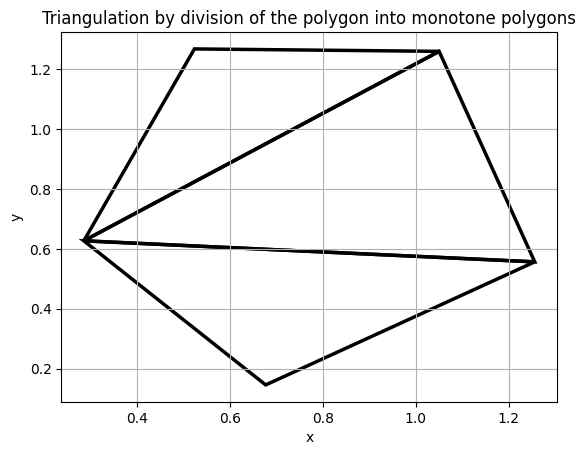

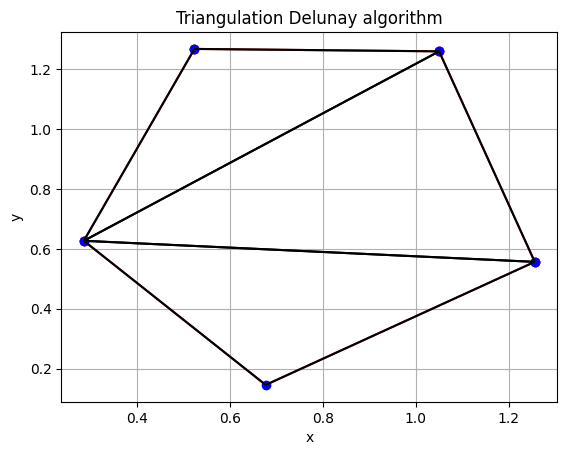

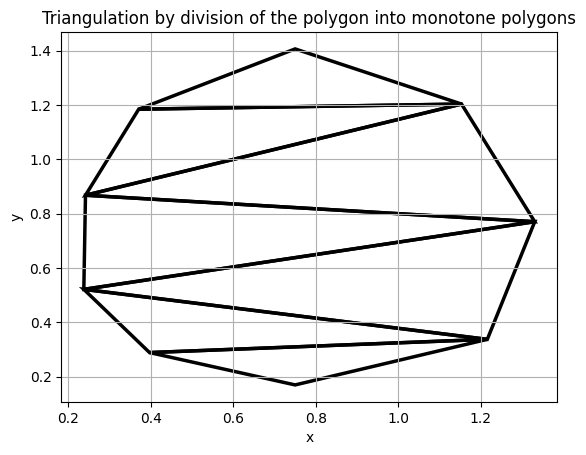

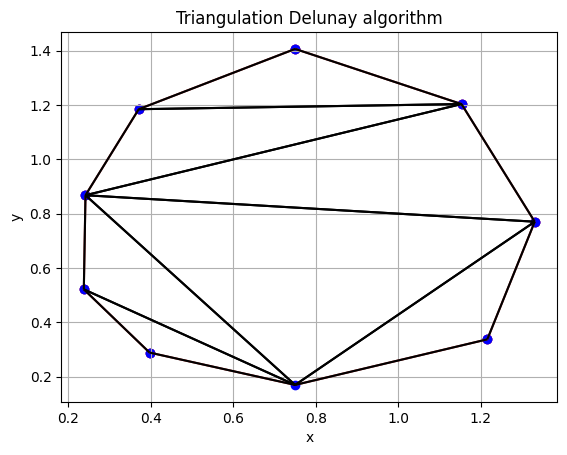

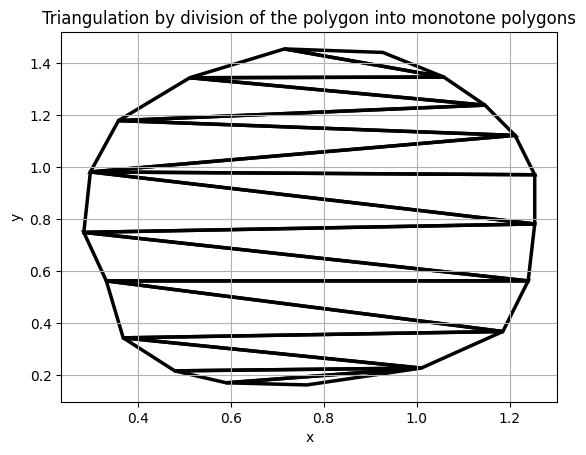

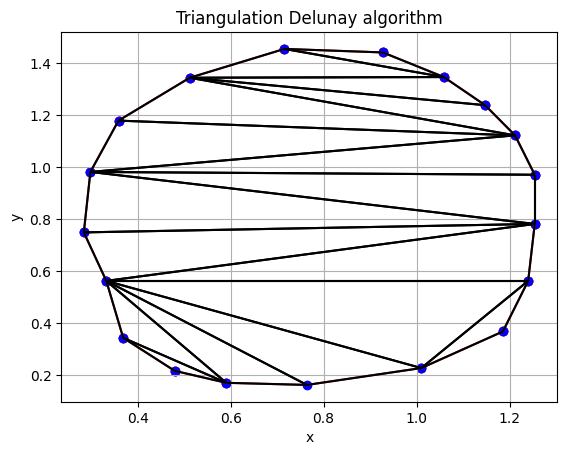

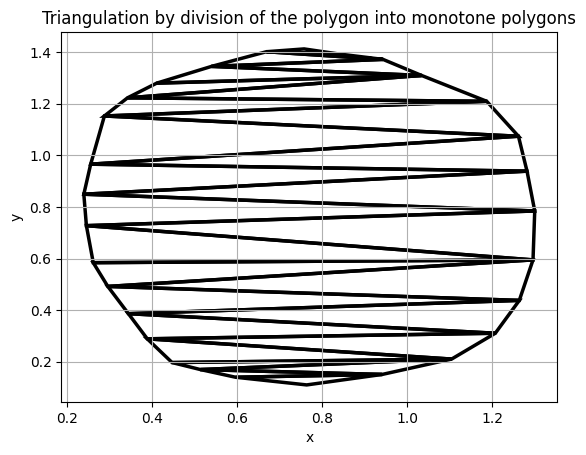

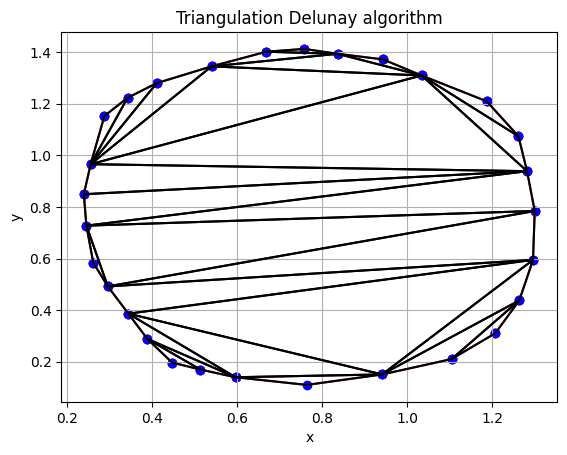

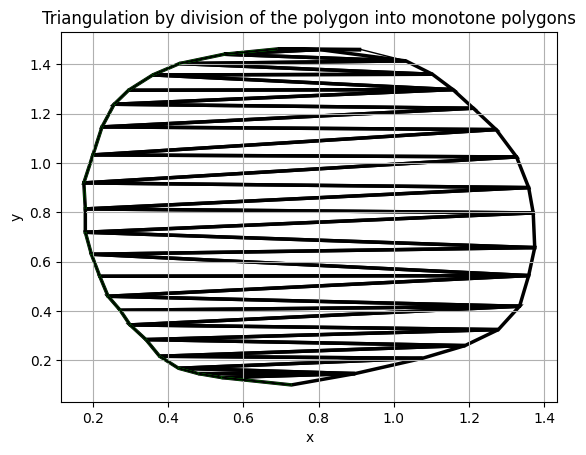

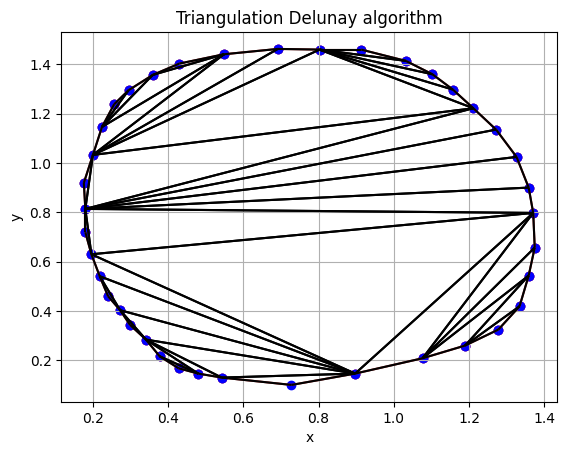

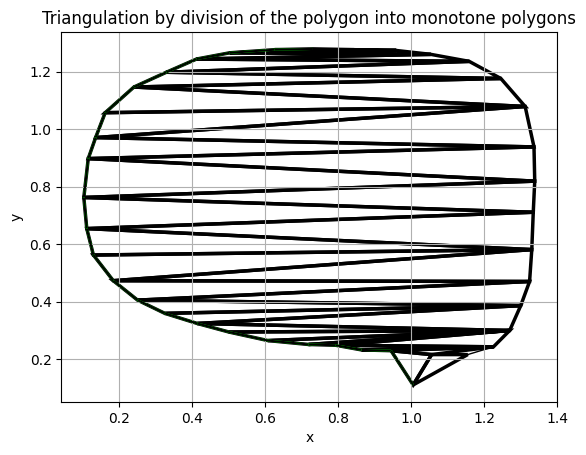

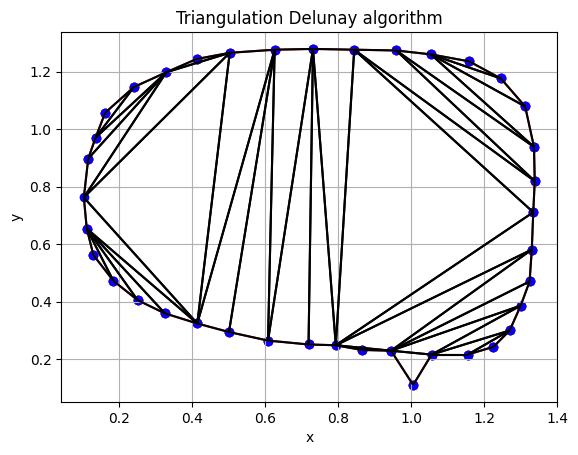

In [1408]:
print("Prawie foremne wielokąty")
for i in range(len(t1)):
    print("Test ",i,"; czas :")

    print("Metoda podzialu na wielokaty monotoniczne:\n")
    %timeit triang_polygon_vis(t1[i])
    visFirst = triang_polygon_vis(t1[i])
    visFirst.show()

    print('\n')

    print("Algorytm triangulacji Delone:\n")
    %timeit delunay(t1[i])
    _, visDelone = delunayDraw(t1[i])
    visDelone.show()

    print('\n')

### Test 2

In [1409]:
t2 = [
    [(0.5383064516129032, 0.24296536796536794), (0.7540322580645161, 0.6677489177489175),
     (0.9435483870967742, 0.2348484848484848), (0.9274193548387097, 0.8138528138528138),
     (1.3810483870967742, 0.8084415584415583), (0.9274193548387097, 1.0817099567099566),
     (1.3629032258064515, 1.390151515151515), (0.7903225806451613, 1.2278138528138527),
     (0.6693548387096774, 1.4740259740259738), (0.5907258064516129, 1.2034632034632033),
     (0.1552419354838709, 1.2765151515151514), (0.5141129032258064, 1.03030303030303),
     (0.13508064516129029, 0.7543290043290041), (0.5685483870967741, 0.7732683982683981)]
    ,
    [(0.5040322580645161, 0.132034632034632), (0.6209677419354839, 0.5703463203463202),
     (0.7278225806451613, 0.1455627705627705), (0.7399193548387096, 0.581168831168831),
     (0.9274193548387097, 0.19155844155844154), (0.8346774193548387, 0.5919913419913418),
     (1.1129032258064515, 0.27272727272727265), (0.935483870967742, 0.6758658008658007),
     (1.2560483870967742, 0.6325757575757573), (0.9516129032258065, 0.8814935064935063),
     (1.2600806451612903, 0.9734848484848484), (0.9173387096774193, 1.0438311688311688),
     (1.122983870967742, 1.4009740259740258), (0.7661290322580645, 1.1006493506493504),
     (0.7600806451612903, 1.425324675324675), (0.6149193548387096, 1.0925324675324675),
     (0.43145161290322576, 1.3928571428571426), (0.4092741935483871, 1.0248917748917747),
     (0.18346774193548385, 1.0844155844155843), (0.3709677419354839, 0.9112554112554112),
     (0.10080645161290316, 0.7732683982683981), (0.3608870967741935, 0.7705627705627704),
     (0.1451612903225806, 0.4891774891774891), (0.44354838709677413, 0.7353896103896103),
     (0.27419354838709675, 0.3051948051948052), (0.5504032258064516, 0.654220779220779)]
    ,
    [(0.38306451612903225, 0.3106060606060605), (0.564516129032258, 0.5622294372294372),
     (0.564516129032258, 0.2916666666666666), (0.6532258064516129, 0.5432900432900432),
     (0.721774193548387, 0.2916666666666666), (0.7560483870967741, 0.5297619047619047),
     (0.9012096774193548, 0.2781385281385281), (0.8830645161290323, 0.5487012987012987),
     (1.094758064516129, 0.34848484848484845), (0.9798387096774193, 0.6136363636363635),
     (1.221774193548387, 0.45941558441558433), (1.0463709677419355, 0.7435064935064934),
     (1.316532258064516, 0.6704545454545454), (1.0846774193548387, 0.849025974025974),
     (1.3225806451612903, 0.8652597402597402), (1.096774193548387, 0.976190476190476),
     (1.3387096774193548, 1.0681818181818181), (1.0745967741935483, 1.114177489177489),
     (1.2620967741935483, 1.2819264069264067), (0.9879032258064515, 1.206168831168831),
     (1.0282258064516128, 1.4334415584415583), (0.844758064516129, 1.2440476190476188),
     (0.752016129032258, 1.4496753246753245), (0.7459677419354839, 1.2088744588744587),
     (0.6028225806451613, 1.3928571428571426), (0.6653225806451613, 1.2115800865800863),
     (0.4798387096774194, 1.3549783549783547), (0.5, 1.1114718614718613), (0.3629032258064516, 1.2873376623376622),
     (0.44758064516129026, 1.0519480519480517), (0.2137096774193548, 1.0925324675324675),
     (0.405241935483871, 0.9680735930735929), (0.22580645161290316, 0.903138528138528),
     (0.407258064516129, 0.857142857142857), (0.23387096774193541, 0.7110389610389609),
     (0.44758064516129026, 0.7380952380952379), (0.24999999999999997, 0.5324675324675323),
     (0.4979838709677419, 0.6569264069264067), (0.30645161290322576, 0.3917748917748917),
     (0.4818548387096774, 0.5514069264069263)]

]

Gwiazdy
Test  0 ; czas :
Metoda podzialu na wielokaty monotoniczne:

316 µs ± 2.52 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Algorytm triangulacji Delone:

9.08 ms ± 8.11 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Test  1 ; czas :
Metoda podzialu na wielokaty monotoniczne:

571 µs ± 683 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Algorytm triangulacji Delone:

26.5 ms ± 34.4 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Test  2 ; czas :
Metoda podzialu na wielokaty monotoniczne:

910 µs ± 4.25 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Algorytm triangulacji Delone:

56.2 ms ± 337 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


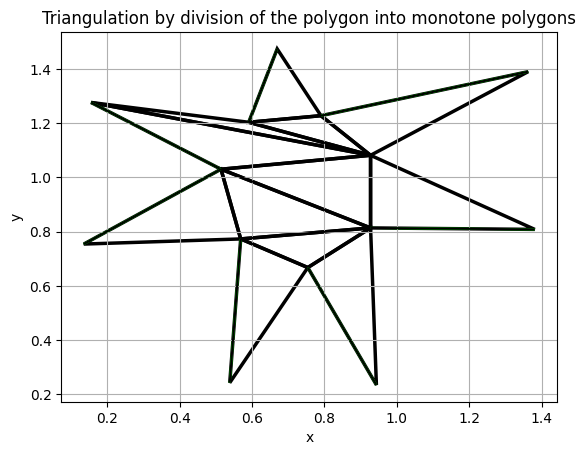

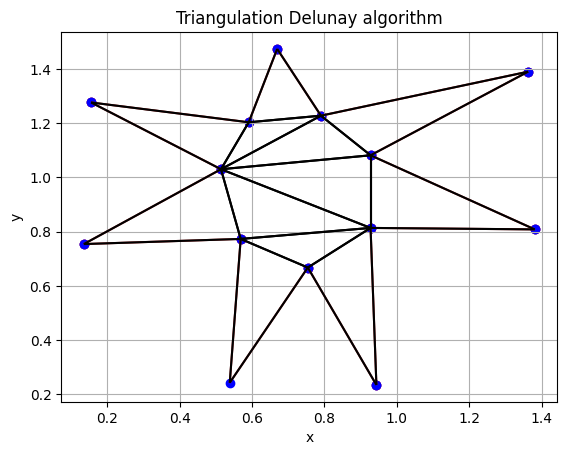

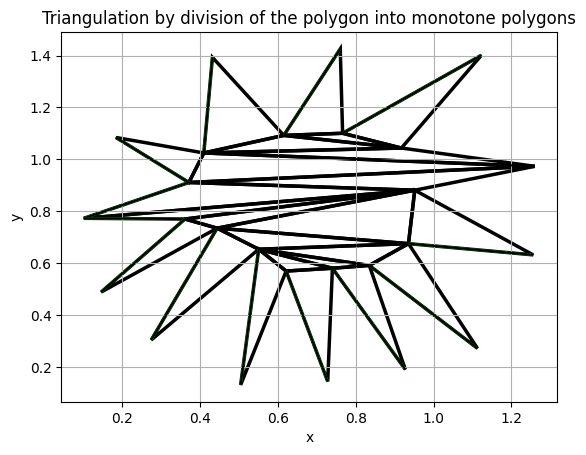

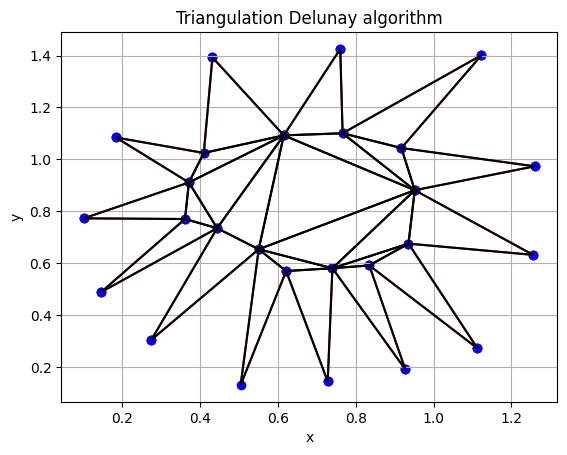

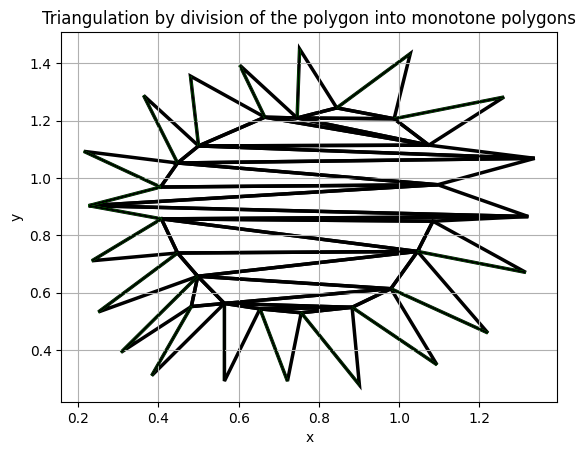

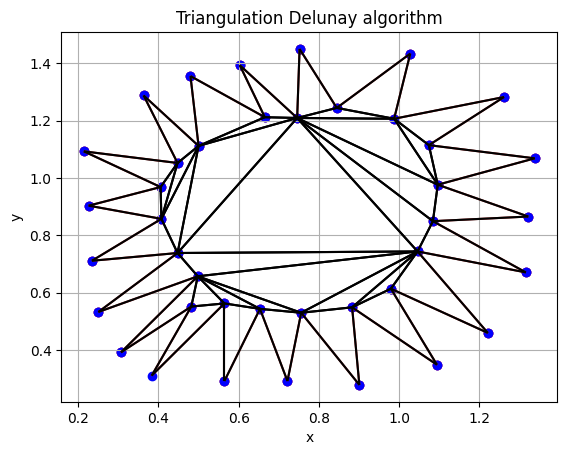

In [1410]:
print("Gwiazdy")
for i in range(len(t2)):
    print("Test ",i,"; czas :")

    print("Metoda podzialu na wielokaty monotoniczne:\n")
    %timeit triang_polygon_vis(t2[i])
    visFirst = triang_polygon_vis(t2[i])
    visFirst.show()

    print('\n')

    print("Algorytm triangulacji Delone:\n")
    %timeit delunay(t2[i])
    _, visDelone = delunayDraw(t2[i])
    visDelone.show()

### Test 3

In [1411]:
t3 = [
    [(0.10483870967741929, 0.16179653679653677), (1.3891129032258065, 0.17532467532467527),
     (1.3629032258064515, 0.2916666666666666), (0.8125, 0.3187229437229437), (0.816532258064516, 0.46482683982683975),
     (1.3951612903225805, 0.49999999999999994), (0.814516129032258, 0.6920995670995669), (1.375, 0.7408008658008656),
     (0.814516129032258, 0.8436147186147185), (1.3508064516129032, 0.9058441558441557),
     (0.8245967741935483, 0.9788961038961037), (1.3084677419354838, 1.103354978354978),
     (0.8346774193548387, 1.1682900432900432), (1.2943548387096773, 1.2683982683982682),
     (0.816532258064516, 1.3143939393939392), (0.7137096774193548, 1.4848484848484846),
     (0.6532258064516129, 1.3306277056277054), (0.28629032258064513, 1.2819264069264067),
     (0.5483870967741935, 1.187229437229437), (0.27217741935483863, 1.0979437229437228),
     (0.5887096774193548, 0.9924242424242422), (0.24999999999999997, 0.9085497835497833),
     (0.564516129032258, 0.8165584415584415), (0.24193548387096772, 0.6839826839826839),
     (0.5987903225806451, 0.6704545454545454), (0.12298387096774191, 0.49999999999999994), (0.625, 0.46482683982683975),
     (0.6108870967741935, 0.34036796536796526)]
    ,
    [(0.10483870967741929, 0.41071428571428564), (1.3931451612903225, 0.4188311688311687),
     (1.2419354838709677, 0.6596320346320346), (1.4213709677419355, 0.7678571428571428),
     (1.247983870967742, 0.884199134199134), (1.3850806451612903, 0.9707792207792207),
     (1.252016129032258, 1.049242424242424), (1.3407258064516128, 1.1628787878787876),
     (1.217741935483871, 1.2278138528138527), (1.1532258064516128, 1.452380952380952),
     (1.0786290322580645, 1.252164502164502), (0.9899193548387097, 1.2034632034632033),
     (1.0806451612903225, 1.1006493506493504), (0.9758064516129032, 1.0167748917748916),
     (1.096774193548387, 0.9193722943722942), (0.9596774193548387, 0.7867965367965366),
     (1.0806451612903225, 0.6596320346320346), (0.532258064516129, 0.6406926406926405),
     (0.786290322580645, 0.7678571428571428), (0.5806451612903225, 0.8950216450216448),
     (0.780241935483871, 0.9897186147186146), (0.564516129032258, 1.1385281385281383),
     (0.7459677419354839, 1.1980519480519478), (0.5685483870967741, 1.279220779220779),
     (0.502016129032258, 1.4767316017316015), (0.39919354838709675, 1.2900432900432899),
     (0.1915322580645161, 1.2359307359307357), (0.38508064516129026, 1.0898268398268396),
     (0.19354838709677416, 1.0519480519480517), (0.405241935483871, 0.9085497835497833),
     (0.1774193548387096, 0.849025974025974), (0.39717741935483863, 0.6731601731601731),
     (0.14112903225806447, 0.5919913419913418)]
    ,
    [(1.54621988830541, 0.7270598254204814), (6.9392348087021745, 0.6738343623589529),
     (6.697507710260899, 2.44358100915478), (6.847545219638242, 3.162124760485417),
     (7.597732766524963, 3.2818820523738563), (6.955905643077436, 4.545986800085162),
     (7.81445361340335, 5.1447732595273585), (6.9058931399516545, 6.062912497338727),
     (7.956155705593064, 6.887907174792421), (6.997582729015587, 7.726208218011497),
     (7.8477952821538715, 8.53789652969981), (6.680836875885637, 9.788694911645731),
     (5.72226389930816, 8.737492016180541), (6.172376427440193, 8.165318288269107),
     (5.472201383679254, 6.941132637853949), (5.747270150871051, 6.222588886523313),
     (5.322163874301909, 5.197998722588887), (5.788947236809202, 4.772195018096658),
     (5.297157622739018, 4.080263998296786), (5.788947236809202, 3.401639344262296),
     (5.5472201383679245, 2.6564828614008946), (3.98016170709344, 2.4968064722163086),
     (3.880136700841877, 3.587928464977646), (4.338584646161541, 3.5213966361507345),
     (3.880136700841877, 4.838726846923569), (4.571976327415188, 4.865339578454332),
     (3.9551554555305493, 6.062912497338727), (4.630324247728598, 6.235895252288696),
     (4.046845044594482, 7.087502661273152), (4.638659664916229, 7.606450926123058),
     (4.01350337584396, 8.11209282520758), (4.530299241477035, 8.750798381945923),
     (3.7801116945903144, 9.522567596338089), (3.104942902392265, 8.684266553119013),
     (3.388347086771693, 8.018948264849904), (2.8882220555138782, 7.287098147753886),
     (3.2716512461448697, 6.901213540557803), (2.738184546136534, 6.02299340004258),
     (3.2716512461448697, 5.530657866723441), (2.6548303742602317, 4.652437726208218),
     (2.9882470617654415, 4.253246753246753), (2.904892889889139, 2.8294656163508622),
     (2.171376177377678, 2.616563764104748), (1.929649078936401, 3.854055780285289),
     (2.4131032758189543, 3.9472003406429637), (1.7796115695590564, 5.291143282946562),
     (2.288072018004501, 5.450819672131148), (1.8629657414353589, 6.515328933361721),
     (2.3380845211302828, 6.70161805407707), (1.9463199133116613, 7.579838194592293),
     (2.446444944569476, 7.619757291888439), (1.929649078936401, 8.591121992761337),
     (2.5798116195715592, 8.404832872045986), (1.6545803117446027, 9.41611667021503),
     (0.8127031757939487, 8.404832872045986), (1.3461698758022838, 8.391526506280604),
     (0.7210135867300158, 6.914519906323186), (1.1877969492373093, 7.087502661273152),
     (0.762690672668167, 5.983074302746434), (1.1794615320496793, 6.129444326165638),
     (0.7376844211052762, 4.8254204811581864), (1.2294740351754605, 4.998403236108155),
     (0.43760940235058765, 3.5746220992122635), (1.1127781945486372, 4.053651266766021),
     (0.5793114945403017, 2.8959974451777737), (1.237809452363091, 3.162124760485417),
     (1.146119863299158, 2.470193740685544), (0.4459448195382181, 0.8202043857781565)]


]

Choinki
Test  0 ; czas :
Metoda podzialu na wielokaty monotoniczne:

181 µs ± 172 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


Algorytm triangulacji Delone:

30.6 ms ± 45 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Test  1 ; czas :
Metoda podzialu na wielokaty monotoniczne:

590 µs ± 377 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Algorytm triangulacji Delone:

41.1 ms ± 36.9 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Test  2 ; czas :
Metoda podzialu na wielokaty monotoniczne:

1.34 ms ± 2.09 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Algorytm triangulacji Delone:

157 ms ± 118 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


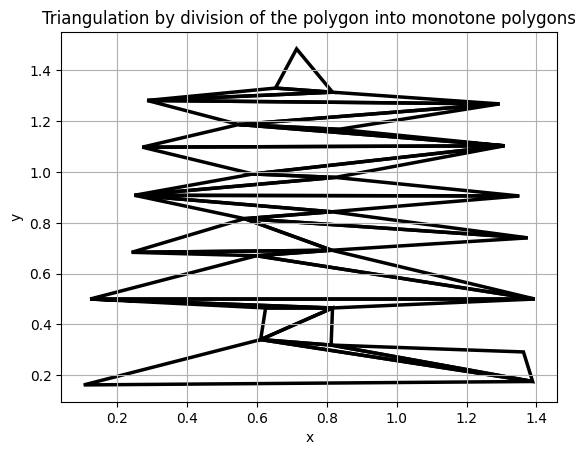

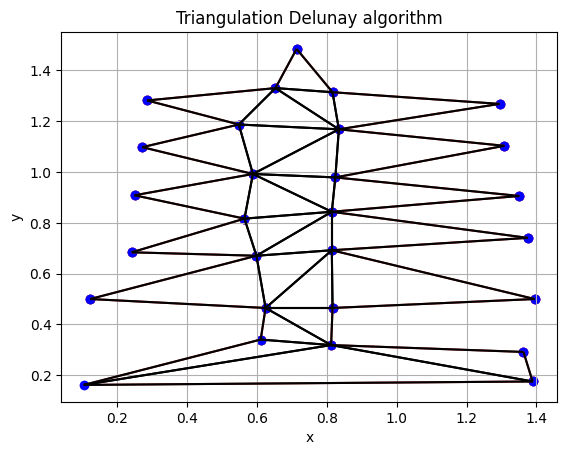

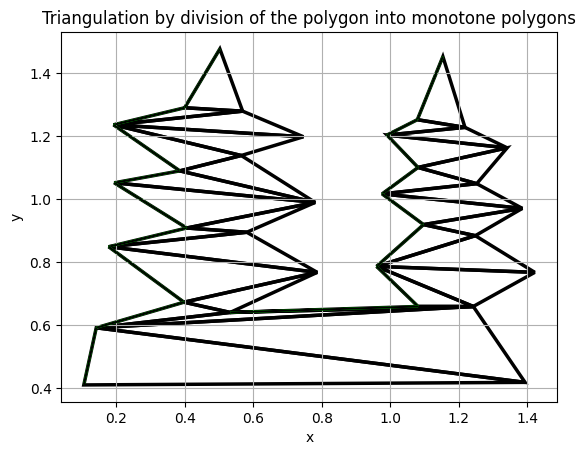

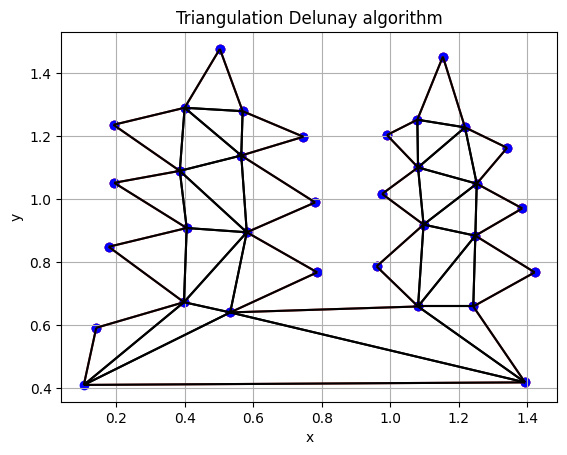

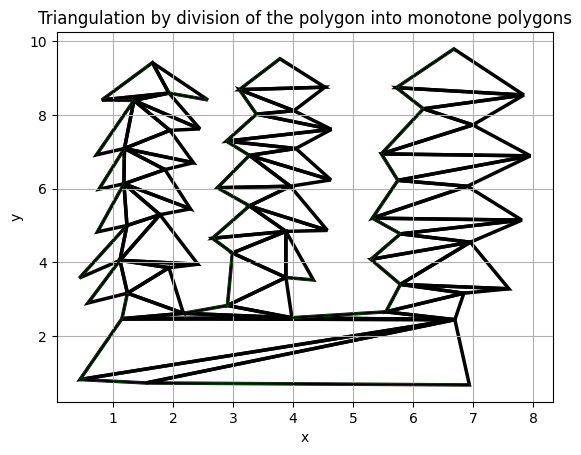

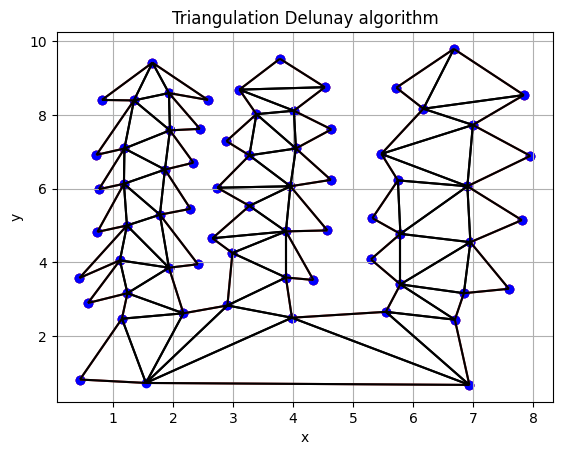

In [1412]:
print("Choinki")
for i in range(len(t3)):
    print("Test ",i,"; czas :")

    print("Metoda podzialu na wielokaty monotoniczne:\n")
    %timeit triang_polygon_vis(t3[i])
    visFirst = triang_polygon_vis(t3[i])
    visFirst.show()

    print('\n')

    print("Algorytm triangulacji Delone:\n")
    %timeit delunay(t3[i])
    _, visDelone = delunayDraw(t3[i])
    visDelone.show()

### Test 4

In [1413]:
t4 =[
    [(0.3084677419354839, 0.21861471861471854), (1.3084677419354838, 0.251082251082251),
     (1.3508064516129032, 0.7705627705627704), (0.4415322580645161, 0.7813852813852813),
     (0.46169354838709675, 1.0817099567099566), (1.280241935483871, 1.133116883116883),
     (1.280241935483871, 1.4307359307359304), (0.23387096774193541, 1.333333333333333),
     (0.1915322580645161, 0.5784632034632033), (1.0504032258064515, 0.5919913419913418),
     (1.0625, 0.3917748917748917), (0.1290322580645161, 0.40259740259740256)]
    ,
     [(0.21169354838709672, 0.3106060606060605), (0.7459677419354839, 0.14826839826839822),
      (1.3044354838709677, 0.17532467532467527), (1.3608870967741935, 0.6975108225108224),
      (0.4717741935483871, 0.8625541125541125), (0.3709677419354839, 1.1249999999999998),
      (1.066532258064516, 1.0627705627705626), (1.2943548387096773, 1.390151515151515),
      (0.2620967741935484, 1.4334415584415583), (0.12499999999999997, 0.9545454545454544),
      (0.4798387096774194, 0.5432900432900432), (1.036290322580645, 0.5676406926406925),
      (1.0120967741935483, 0.34307359307359303), (0.2137096774193548, 0.5568181818181817)]
     ,
      [(0.2842741935483871, 0.36201298701298695), (0.5403225806451613, 0.1942640692640692),
       (1.0806451612903225, 0.15909090909090906), (1.3508064516129032, 0.4485930735930735),
       (1.3205645161290323, 0.7949134199134198), (0.7580645161290323, 0.7759740259740258),
       (0.33870967741935476, 0.8354978354978353), (0.4818548387096774, 1.1304112554112553),
       (1.1068548387096773, 1.0844155844155843), (1.3528225806451613, 1.3225108225108222),
       (0.8508064516129032, 1.49025974025974), (0.4032258064516129, 1.4334415584415583),
       (0.2016129032258064, 1.1439393939393938), (0.17943548387096772, 0.6406926406926405),
       (0.44354838709677413, 0.5216450216450215), (0.8568548387096775, 0.573051948051948),
       (0.9576612903225805, 0.3674242424242424), (0.5604838709677419, 0.41071428571428564)]
     ,
     [(0.23790322580645154, 0.14826839826839822), (0.5987903225806451, 0.1455627705627705),
      (1.1149193548387097, 0.13474025974025972), (1.3709677419354838, 0.15638528138528135),
      (1.3911290322580645, 0.3538961038961039), (1.3810483870967742, 0.6028138528138527),
      (1.3366935483870968, 0.7516233766233764), (0.973790322580645, 0.6839826839826839),
      (0.721774193548387, 0.5784632034632033), (0.4334677419354839, 0.654220779220779),
      (0.3931451612903225, 0.8814935064935063), (0.6471774193548386, 0.9599567099567099),
      (1.1491935483870968, 0.922077922077922), (1.379032258064516, 1.0627705627705626),
      (1.348790322580645, 1.379329004329004), (0.9294354838709677, 1.4415584415584413),
      (0.3568548387096774, 1.4307359307359304), (0.1915322580645161, 1.2575757575757573),
      (0.3165322580645161, 1.1520562770562768), (0.6008064516129032, 1.2196969696969695),
      (0.877016129032258, 1.2711038961038958), (1.2076612903225805, 1.2115800865800863),
      (1.1774193548387097, 1.0654761904761902), (0.6532258064516129, 1.103354978354978),
      (0.3548387096774194, 1.041125541125541), (0.20362903225806447, 0.8896103896103895),
      (0.2641129032258064, 0.5595238095238093), (0.38306451612903225, 0.4323593073593072),
      (0.6955645161290323, 0.37012987012987003), (1.1209677419354838, 0.5459956709956708),
      (1.25, 0.45670995670995657), (1.2318548387096773, 0.3106060606060605),
      (0.9233870967741935, 0.3051948051948052), (0.5927419354838709, 0.25649350649350644),
      (0.3407258064516129, 0.29978354978354976), (0.1774193548387096, 0.3322510822510822),
      (0.12096774193548385, 0.22402597402597396)]
]

t5 = [
 [(0.5443548387096775, 8.879870129870131), (0.5745967741935485, 7.729978354978355),
  (1.6028225806451615, 4.442640692640693), (2.3891129032258065, 0.8441558441558441),
  (2.7419354838709675, 3.942099567099567), (3.7298387096774195, 1.0470779220779223),
  (4.193548387096774, 3.8474025974025974), (4.889112903225806, 0.8576839826839828),
  (5.262096774193548, 3.6850649350649354), (6.018145161290322, 1.0876623376623376),
  (6.532258064516128, 4.090909090909092), (6.441532258064516, 6.174242424242425),
  (8.084677419354838, 6.580086580086581), (8.15524193548387, 8.406385281385282),
  (7.419354838709676, 8.758116883116884), (6.945564516129032, 9.62391774891775),
  (6.381048387096774, 8.474025974025976), (4.314516129032258, 5.94426406926407),
  (2.0766129032258065, 6.2148268398268405)]
 ,
 [(1.310483870967742, 1.0470779220779223), (7.328629032258064, 0.9523809523809526),
  (7.368951612903226, 2.372835497835498), (2.7923387096774195, 2.6975108225108224),
  (2.7620967741935485, 4.0773809523809526), (6.975806451612902, 4.050324675324676),
  (7.076612903225806, 4.9567099567099575), (3.2762096774193545, 5.808982683982685),
  (3.1552419354838706, 6.8777056277056285), (7.983870967741934, 5.75487012987013),
  (8.679435483870968, 7.2023809523809526), (1.118951612903226, 8.582251082251084)]
 ,
 [(7.046370967741934, 0.7629870129870131), (7.036290322580644, 2.6569264069264076),
  (2.7822580645161294, 3.170995670995671), (2.6512096774193545, 4.780844155844156),
  (6.048387096774194, 5.0108225108225115), (5.9375, 6.67478354978355),
  (3.0040322580645165, 7.188852813852815), (2.9939516129032255, 8.027597402597403),
  (4.929435483870968, 8.189935064935066), (4.879032258064516, 8.933982683982684),
  (1.370967741935484, 9.055735930735931), (1.1693548387096775, 0.9659090909090908)]
 ,
 [(6.854838709677418, 1.1282467532467533), (6.824596774193548, 2.738095238095238),
  (4.04233870967742, 3.0221861471861473), (3.9919354838709675, 4.726731601731602),
  (6.754032258064516, 4.848484848484849), (6.653225806451612, 6.7694805194805205),
  (2.3991935483870965, 7.121212121212121), (2.2983870967741935, 1.222943722943723)]

]

Weze
Test  0 ; czas :
Metoda podzialu na wielokaty monotoniczne:

235 µs ± 380 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Algorytm triangulacji Delone:

7.87 ms ± 31.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Test  1 ; czas :
Metoda podzialu na wielokaty monotoniczne:

285 µs ± 545 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Algorytm triangulacji Delone:

9.67 ms ± 7.25 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Test  2 ; czas :
Metoda podzialu na wielokaty monotoniczne:

367 µs ± 207 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Algorytm triangulacji Delone:

17.4 ms ± 5.67 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
Test  3 ; czas :
Metoda podzialu na wielokaty monotoniczne:

742 µs ± 6.51 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Algorytm triangulacji Delone:

53.8 ms ± 400 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


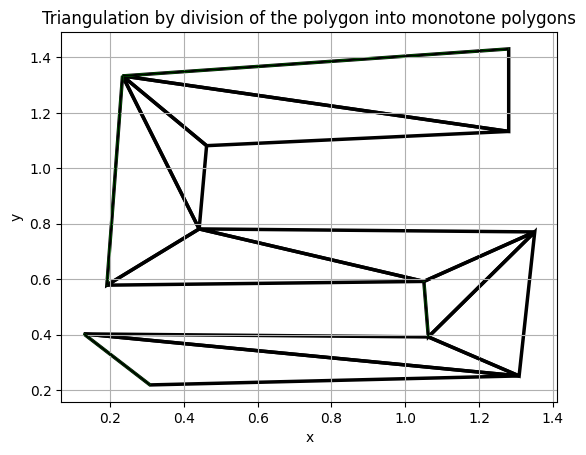

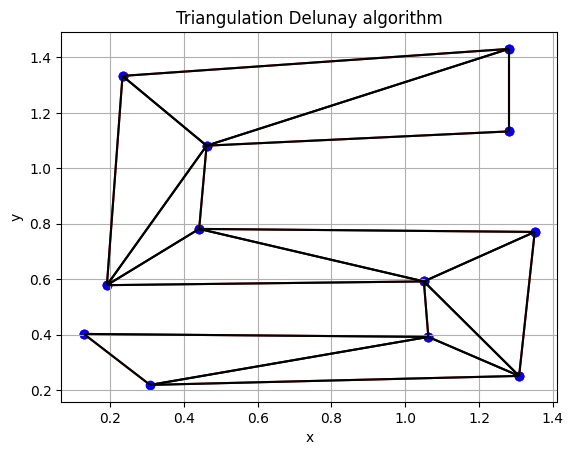

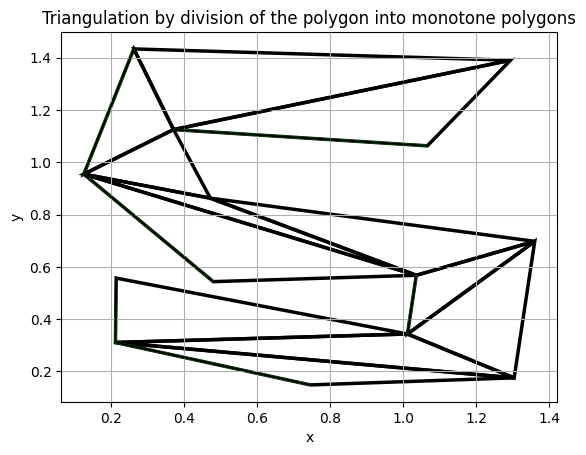

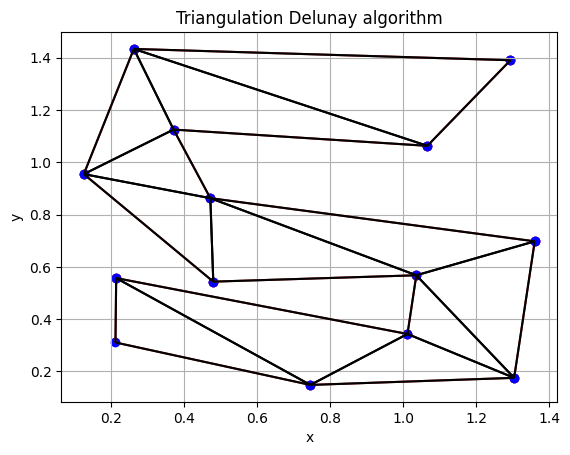

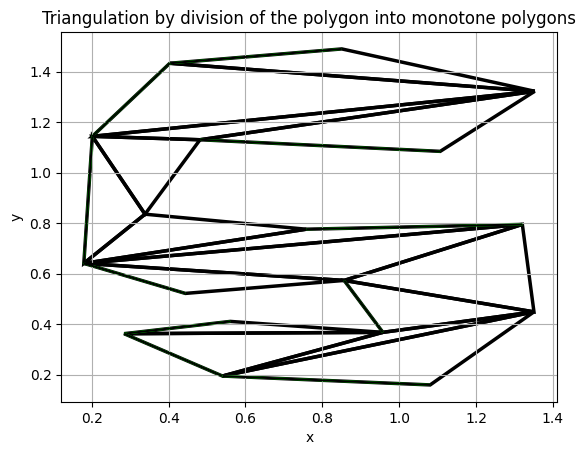

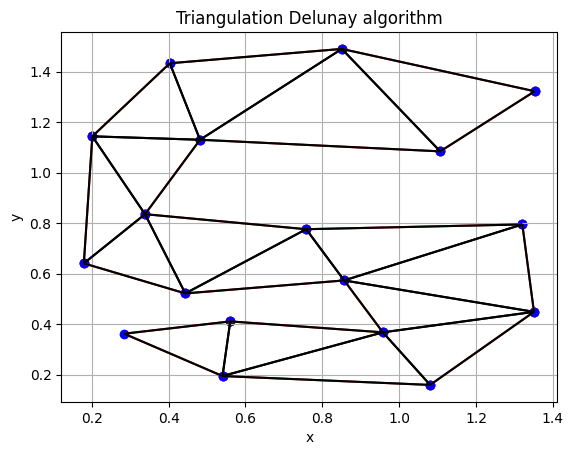

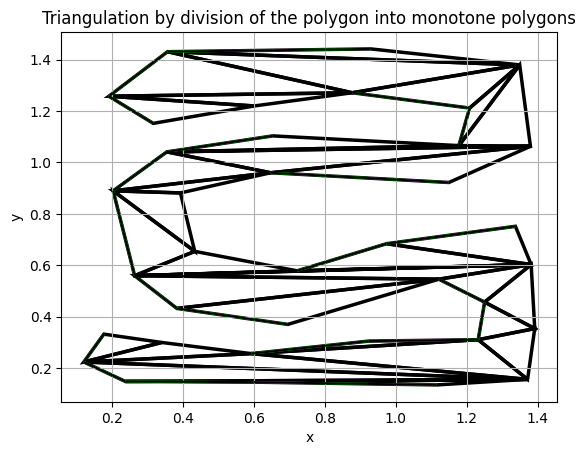

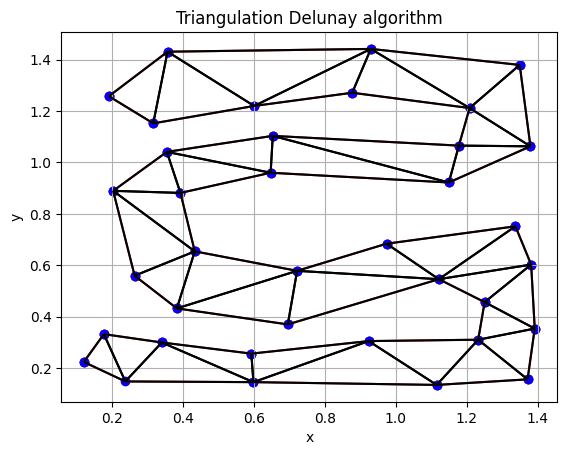

In [1414]:
print("Weze")
for i in range(len(t4)):
    print("Test ",i,"; czas :")

    print("Metoda podzialu na wielokaty monotoniczne:\n")
    %timeit triang_polygon_vis(t4[i])
    visFirst = triang_polygon_vis(t4[i])
    visFirst.show()

    print('\n')

    print("Algorytm triangulacji Delone:\n")
    %timeit delunay(t4[i])
    _, visDelone = delunayDraw(t4[i])
    visDelone.show()

### Ponziej nalezy wpisac punkty w kolejnosci od lewej strony jako swoj przyklad a nastepnie
### wygeneruje sie gif ktory zostanie umieszony w folderze gifs/

In [1415]:
# Nalezy wpisac tutaj swoj wielokat ówczesniej wygenerowany poprzez PointSelect.py
your_test = [(2.8931451612903225, 2.021103896103896),
         (4.858870967741936, 3.617424242424243),
         (6.481854838709676, 2.575757575757576),
         (7.883064516129032, 4.767316017316018),
         (4.798387096774194, 6.228354978354979),
         (3.6491935483870965, 3.9015151515151523),
         (1.431451612903226, 3.495670995670996)]


In [1416]:
# Aby zapisac jako Gif swoj przyklad nalezy odkomentowac linije 6 oraz 7
if len(your_test) >= 3:
    visFirst = triang_polygon_vis(your_test)  # podzial na monotoniczne czesci
    listEdges, visDelonay = delunayDraw(your_test) # delone

    # visDelonay.save_gif(f"{os.getcwd()}/gifsPresentation/delone_gif",interval = 350)
    # visFirst.save_gif(f"{os.getcwd()}/gifsPresentation/mono_gif",interval = 350)